In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import time
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
from tqdm import tqdm
import os
from PIL import Image
from torchsummary import summary
import torchvision.transforms as transforms
import time

# Montamos la unidad de drive y trabajamos con los datasets y modelos preparados
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
models_list = []
train_losses_list = []
train_accuracies_list = []
val_losses_list = []
val_accuracies_list = []

In [ ]:
modelsdir = '/content/drive/MyDrive/combined'

datasetdir = '/content/drive/MyDrive/cbis-ddsm'
X_train_1 = torch.load(datasetdir + "/X_train_balanced.pt")
y_train_1 = torch.load(datasetdir + "/y_train_balanced.pt")
X_test_1 = torch.load(datasetdir + "/X_test.pt")
y_test_1 = torch.load(datasetdir + "/y_test.pt")

X_tensor = torch.load("/content/drive/MyDrive/output/X_oversampled.pt")
y_tensor = torch.load("/content/drive/MyDrive/output/y_oversampled.pt")

from sklearn.model_selection import train_test_split
test_size = 0.2
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_tensor, y_tensor, test_size=test_size, random_state=42)

X_train_full = torch.cat((X_train_1, X_train_2), dim=0)
y_train_full = torch.cat((y_train_1, y_train_2), dim=0)
X_test_full = torch.cat((X_test_1, X_test_2), dim=0)
y_test_full = torch.cat((y_test_1, y_test_2), dim=0)

In [ ]:
# Dataset y DataLoader
X_train = X_train_full
y_train = y_train_full
X_test = X_test_full
y_test = y_test_full

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [ ]:
# @title Funciones de utilidades

## Definición de clase para el callback "Early Stopping" con guardado de modelo
class EarlyStopping:
    def __init__(self, path, patience=3, verbose=False, delta=0.001):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.val_loss_min = float('inf')
        self.path = path  # Archivo donde guardaremos el modelo

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping no mejoró por {self.counter} épocas')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if val_loss < self.val_loss_min:
            if self.verbose:
                print(f'Pérdida de validación mejorada a {val_loss:.6f}. Guardando modelo...')
            torch.save(model, self.path)  # Guardamos el modelo a fichero
            self.val_loss_min = val_loss

def trainModel(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, early_stopping, transforms):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0
        correct_train = 0
        total_train = 0

        model.train()  # Modo de entrenamiento

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            if transforms:
                transformed_images = torch.stack([transforms(image) for image in images])
                images, labels = transformed_images.to(device), labels.to(device)
            else:
                images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Precisión del entrenamiento
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validación
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0


        with torch.no_grad():
          for images, labels in val_loader:
            if transforms:
                transformed_images = torch.stack([transforms(image) for image in images])
                images, labels = transformed_images.to(device), labels.to(device)
            else:
                images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

          _, predicted = torch.max(outputs, 1)
          total_val += labels.size(0)
          correct_val += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        epoch_duration = end_time - start_time  # Duración de la época

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.3f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Time: {epoch_duration:.2f} seconds")

        # Aplicar Early Stopping y guardar modelo si corresponde
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early Stopping activado. Proceso detenido!")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

def metrics(model, test_loader, transforms):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.eval()

  all_preds = []
  all_labels = []

  for images, labels in test_loader:
      if transforms:
          transformed_images = torch.stack([transforms(image) for image in images])
          images, labels = transformed_images.to(device), labels.to(device)
      else:
          images, labels = images.to(device), labels.to(device)

      with torch.no_grad():
          outputs = model(images)

      _, predicted = torch.max(outputs, 1)

      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  conf_matrix = confusion_matrix(all_labels, all_preds)

  plt.figure(figsize=(4, 3))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Cáncer', 'Con Cáncer'], yticklabels=['Sin Cáncer', 'Con Cáncer'])
  plt.xlabel('Predicciones')
  plt.ylabel('Verdadero')
  plt.title('Matriz de Confusión')
  plt.show()

  accuracy = accuracy_score(all_labels, all_preds)
  report = classification_report(all_labels, all_preds, target_names=['Sin Cáncer', 'Con Cáncer'])

  print(f"Precisión global: {accuracy * 100:.2f}%")
  print("Informe y métricas de clasificación:")
  print(report)

  precision = precision_score(all_labels, all_preds)
  recall = recall_score(all_labels, all_preds)
  f1 = f1_score(all_labels, all_preds)
  accuracy = accuracy_score(all_labels, all_preds)

  print(f"Precisión: {precision:.2f}")
  print(f"Sensibilidad (Recall): {recall:.2f}")
  print(f"F1-Score: {f1:.2f}")
  print(f"Accuracy: {accuracy:.2f}")

  true_negatives = conf_matrix[0, 0]
  false_positives = conf_matrix[0, 1]
  true_positives = conf_matrix[1, 0]
  false_negatives = conf_matrix[1, 1]

  specificity = true_negatives / (true_negatives + false_positives)

  print(f"Especificidad: {specificity:.2f}")

def graphLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies):
  fig, axs = plt.subplots(1, 2, figsize=(7, 3))

  axs[0].plot(train_losses, label='Train Loss')
  axs[0].plot(val_losses, label='Val Loss')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Loss')
  axs[0].set_title('Model Loss')
  axs[0].legend(loc='upper left')

  axs[1].plot(train_accuracies, label='Train Accuracy')
  axs[1].plot(val_accuracies, label='Val Accuracy')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Accuracy')
  axs[1].set_title('Model Accuracy')
  axs[1].legend(loc='upper left')

  plt.tight_layout()
  plt.show()

In [ ]:
## TRANSFER LEARNING CON EFFICIENTNET B0

efficientnetb0 = models.efficientnet_b0(pretrained=True)
for param in efficientnetb0.parameters():
    param.requires_grad = False

# Hay que reemplazar la capa clasificadora
num_classes = 2
efficientnetb0.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(efficientnetb0.classifier[1].in_features, num_classes)
)

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repetir el canal de escala de grises para obtener 3 canales
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Valores estándar para modelos pre-entrenados
])

optimizer = optim.Adam(efficientnetb0.classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

fichModelo = modelsdir + '/efficientnetB0.pth'
eaStop = EarlyStopping(fichModelo, patience=15, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnetb0.to(device)
epochs = 50

train_loss, train_accu, val_loss, val_accu = trainModel(efficientnetb0,train_loader,test_loader,criterion,optimizer,epochs,device,eaStop,transform)

Epoch 1/50: 100%|██████████| 619/619 [00:18<00:00, 33.48it/s]


Epoch [1/50], Train Loss: 0.680, Train Accuracy: 58.22%, Val Loss: 0.6490, Val Accuracy: 62.50%, Time: 21.64 seconds
Pérdida de validación mejorada a 0.649036. Guardando modelo...


Epoch 2/50: 100%|██████████| 619/619 [00:17<00:00, 36.31it/s]


Epoch [2/50], Train Loss: 0.661, Train Accuracy: 60.71%, Val Loss: 0.6571, Val Accuracy: 56.25%, Time: 20.12 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 3/50: 100%|██████████| 619/619 [00:16<00:00, 37.13it/s]


Epoch [3/50], Train Loss: 0.660, Train Accuracy: 61.34%, Val Loss: 0.6648, Val Accuracy: 75.00%, Time: 19.69 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 4/50: 100%|██████████| 619/619 [00:16<00:00, 37.04it/s]


Epoch [4/50], Train Loss: 0.651, Train Accuracy: 61.92%, Val Loss: 0.6522, Val Accuracy: 43.75%, Time: 19.87 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 5/50: 100%|██████████| 619/619 [00:16<00:00, 36.64it/s]


Epoch [5/50], Train Loss: 0.654, Train Accuracy: 62.76%, Val Loss: 0.6568, Val Accuracy: 56.25%, Time: 19.97 seconds
EarlyStopping no mejoró por 4 épocas


Epoch 6/50: 100%|██████████| 619/619 [00:16<00:00, 36.65it/s]


Epoch [6/50], Train Loss: 0.655, Train Accuracy: 62.59%, Val Loss: 0.6538, Val Accuracy: 56.25%, Time: 20.00 seconds
EarlyStopping no mejoró por 5 épocas


Epoch 7/50: 100%|██████████| 619/619 [00:16<00:00, 36.61it/s]


Epoch [7/50], Train Loss: 0.652, Train Accuracy: 62.51%, Val Loss: 0.6487, Val Accuracy: 50.00%, Time: 19.98 seconds
EarlyStopping no mejoró por 6 épocas


Epoch 8/50: 100%|██████████| 619/619 [00:16<00:00, 36.43it/s]


Epoch [8/50], Train Loss: 0.651, Train Accuracy: 62.75%, Val Loss: 0.6327, Val Accuracy: 50.00%, Time: 20.09 seconds
Pérdida de validación mejorada a 0.632703. Guardando modelo...


Epoch 9/50: 100%|██████████| 619/619 [00:17<00:00, 35.94it/s]


Epoch [9/50], Train Loss: 0.647, Train Accuracy: 63.56%, Val Loss: 0.6431, Val Accuracy: 56.25%, Time: 20.39 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 10/50: 100%|██████████| 619/619 [00:17<00:00, 35.93it/s]


Epoch [10/50], Train Loss: 0.654, Train Accuracy: 61.96%, Val Loss: 0.6453, Val Accuracy: 56.25%, Time: 20.37 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 11/50: 100%|██████████| 619/619 [00:17<00:00, 35.86it/s]


Epoch [11/50], Train Loss: 0.652, Train Accuracy: 62.45%, Val Loss: 0.6619, Val Accuracy: 50.00%, Time: 20.41 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 12/50: 100%|██████████| 619/619 [00:17<00:00, 35.95it/s]


Epoch [12/50], Train Loss: 0.654, Train Accuracy: 62.86%, Val Loss: 0.6405, Val Accuracy: 56.25%, Time: 20.44 seconds
EarlyStopping no mejoró por 4 épocas


Epoch 13/50: 100%|██████████| 619/619 [00:17<00:00, 36.09it/s]


Epoch [13/50], Train Loss: 0.652, Train Accuracy: 62.55%, Val Loss: 0.6422, Val Accuracy: 56.25%, Time: 20.29 seconds
EarlyStopping no mejoró por 5 épocas


Epoch 14/50: 100%|██████████| 619/619 [00:17<00:00, 35.80it/s]


Epoch [14/50], Train Loss: 0.653, Train Accuracy: 62.96%, Val Loss: 0.6538, Val Accuracy: 56.25%, Time: 20.44 seconds
EarlyStopping no mejoró por 6 épocas


Epoch 15/50: 100%|██████████| 619/619 [00:17<00:00, 35.46it/s]


Epoch [15/50], Train Loss: 0.656, Train Accuracy: 61.84%, Val Loss: 0.6373, Val Accuracy: 56.25%, Time: 20.67 seconds
EarlyStopping no mejoró por 7 épocas


Epoch 16/50: 100%|██████████| 619/619 [00:17<00:00, 36.06it/s]


Epoch [16/50], Train Loss: 0.654, Train Accuracy: 62.90%, Val Loss: 0.6475, Val Accuracy: 62.50%, Time: 20.27 seconds
EarlyStopping no mejoró por 8 épocas


Epoch 17/50: 100%|██████████| 619/619 [00:17<00:00, 35.43it/s]


Epoch [17/50], Train Loss: 0.656, Train Accuracy: 62.51%, Val Loss: 0.6808, Val Accuracy: 62.50%, Time: 20.66 seconds
EarlyStopping no mejoró por 9 épocas


Epoch 18/50: 100%|██████████| 619/619 [00:17<00:00, 35.16it/s]


Epoch [18/50], Train Loss: 0.655, Train Accuracy: 62.34%, Val Loss: 0.6772, Val Accuracy: 62.50%, Time: 20.95 seconds
EarlyStopping no mejoró por 10 épocas


Epoch 19/50: 100%|██████████| 619/619 [00:17<00:00, 35.13it/s]


Epoch [19/50], Train Loss: 0.653, Train Accuracy: 62.62%, Val Loss: 0.6439, Val Accuracy: 56.25%, Time: 20.89 seconds
EarlyStopping no mejoró por 11 épocas


Epoch 20/50: 100%|██████████| 619/619 [00:17<00:00, 35.14it/s]


Epoch [20/50], Train Loss: 0.659, Train Accuracy: 62.36%, Val Loss: 0.6536, Val Accuracy: 62.50%, Time: 20.87 seconds
EarlyStopping no mejoró por 12 épocas


Epoch 21/50: 100%|██████████| 619/619 [00:17<00:00, 35.06it/s]


Epoch [21/50], Train Loss: 0.658, Train Accuracy: 62.22%, Val Loss: 0.6501, Val Accuracy: 50.00%, Time: 20.98 seconds
EarlyStopping no mejoró por 13 épocas


Epoch 22/50: 100%|██████████| 619/619 [00:17<00:00, 35.16it/s]


Epoch [22/50], Train Loss: 0.654, Train Accuracy: 62.37%, Val Loss: 0.6444, Val Accuracy: 56.25%, Time: 20.89 seconds
EarlyStopping no mejoró por 14 épocas


Epoch 23/50: 100%|██████████| 619/619 [00:17<00:00, 35.20it/s]


Epoch [23/50], Train Loss: 0.651, Train Accuracy: 63.04%, Val Loss: 0.6533, Val Accuracy: 56.25%, Time: 20.89 seconds
EarlyStopping no mejoró por 15 épocas
Early Stopping activado. Proceso detenido!


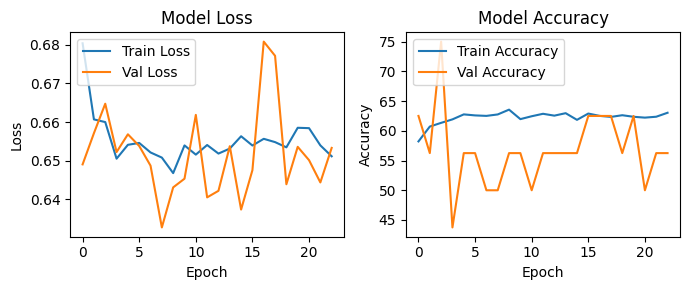

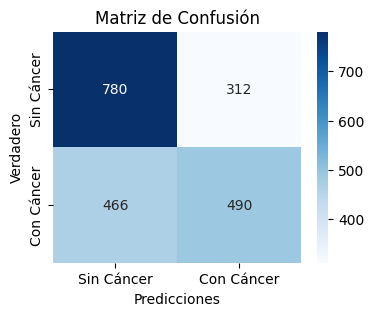

Precisión global: 62.01%
Informe y métricas de clasificación:
              precision    recall  f1-score   support

  Sin Cáncer       0.63      0.71      0.67      1092
  Con Cáncer       0.61      0.51      0.56       956

    accuracy                           0.62      2048
   macro avg       0.62      0.61      0.61      2048
weighted avg       0.62      0.62      0.62      2048

Precisión: 0.61
Sensibilidad (Recall): 0.51
F1-Score: 0.56
Accuracy: 0.62
Especificidad: 0.71


In [ ]:
models_list.append("EfficientNetB0");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(efficientnetb0, test_loader, transform)

In [ ]:
# Bloque MBConv básico
class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio, stride, se_ratio=0.25):
        super(MBConvBlock, self).__init__()
        hidden_channels = in_channels * expand_ratio

        # Bloque de expansión y convolución
        self.expand = nn.Conv2d(in_channels, hidden_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(hidden_channels)

        # Depthwise separable convolution
        self.depthwise_conv = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=stride, padding=1, groups=hidden_channels, bias=False)
        self.bn2 = nn.BatchNorm2d(hidden_channels)

        # Bloque de reducción y convolución de salida
        self.reduce = nn.Conv2d(hidden_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.use_residual = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        y = F.relu6(self.bn1(self.expand(x)))
        y = F.relu6(self.bn2(self.depthwise_conv(y)))
        y = self.bn3(self.reduce(y))

        if self.use_residual:
            y += x  # Residual connection

        return y

# Definición de EfficientNet B0 desde cero partiendo del bloque definido anteriormente
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=2):
        super(EfficientNetB0, self).__init__()

        # Bloque inicial
        self.conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn_stem = nn.BatchNorm2d(32)

        # Bloques MBConv
        self.mbconv1 = MBConvBlock(32, 16, expand_ratio=1, stride=1)
        self.mbconv2 = MBConvBlock(16, 24, expand_ratio=6, stride=2)
        self.mbconv3 = MBConvBlock(24, 40, expand_ratio=6, stride=2)
        self.mbconv4 = MBConvBlock(40, 80, expand_ratio=6, stride=2)
        self.mbconv5 = MBConvBlock(80, 112, expand_ratio=6, stride=1)
        self.mbconv6 = MBConvBlock(112, 192, expand_ratio=6, stride=2)
        self.mbconv7 = MBConvBlock(192, 320, expand_ratio=6, stride=1)

        # Clasificador
        self.conv_head = nn.Conv2d(320, 1280, kernel_size=1, bias=False)
        self.bn_head = nn.BatchNorm2d(1280)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        # Propagación hacia adelante
        x = F.relu6(self.bn_stem(self.conv_stem(x)))
        x = self.mbconv1(x)
        x = self.mbconv2(x)
        x = self.mbconv3(x)
        x = self.mbconv4(x)
        x = self.mbconv5(x)
        x = self.mbconv6(x)
        x = self.mbconv7(x)

        x = F.relu6(self.bn_head(self.conv_head(x)))
        x = self.avgpool(x)  # Pooling promedio adaptativo
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [ ]:
## TRANSFER LEARNING CON EFFICIENTNET B0 arquitectura manual no preentrenada

efficientnetManual = EfficientNetB0(num_classes=2)
optimizer = optim.Adam(efficientnetManual.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

transform = transforms.Compose([
    #transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize([0.485], [0.229])  # Valores estándar para modelos pre-entrenados
])

fichModelo = modelsdir + '/efficientnetB0_manual.pth'
eaStop = EarlyStopping(fichModelo, patience=15, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnetManual.to(device)
epochs = 50

train_loss, train_accu, val_loss, val_accu = trainModel(efficientnetManual,train_loader,test_loader,criterion,optimizer,epochs,device,eaStop,transform)

Epoch 1/50: 100%|██████████| 619/619 [00:23<00:00, 26.31it/s]


Epoch [1/50], Train Loss: 0.700, Train Accuracy: 54.39%, Val Loss: 0.6652, Val Accuracy: 31.25%, Time: 25.08 seconds
Pérdida de validación mejorada a 0.665181. Guardando modelo...


Epoch 2/50: 100%|██████████| 619/619 [00:23<00:00, 26.48it/s]


Epoch [2/50], Train Loss: 0.675, Train Accuracy: 58.54%, Val Loss: 0.7142, Val Accuracy: 43.75%, Time: 24.91 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 3/50: 100%|██████████| 619/619 [00:23<00:00, 26.24it/s]


Epoch [3/50], Train Loss: 0.642, Train Accuracy: 63.88%, Val Loss: 0.6573, Val Accuracy: 50.00%, Time: 25.15 seconds
Pérdida de validación mejorada a 0.657324. Guardando modelo...


Epoch 4/50: 100%|██████████| 619/619 [00:23<00:00, 26.17it/s]


Epoch [4/50], Train Loss: 0.601, Train Accuracy: 67.56%, Val Loss: 0.6393, Val Accuracy: 68.75%, Time: 25.18 seconds
Pérdida de validación mejorada a 0.639347. Guardando modelo...


Epoch 5/50: 100%|██████████| 619/619 [00:23<00:00, 26.18it/s]


Epoch [5/50], Train Loss: 0.553, Train Accuracy: 71.95%, Val Loss: 0.6242, Val Accuracy: 56.25%, Time: 25.19 seconds
Pérdida de validación mejorada a 0.624222. Guardando modelo...


Epoch 6/50: 100%|██████████| 619/619 [00:23<00:00, 25.90it/s]


Epoch [6/50], Train Loss: 0.507, Train Accuracy: 75.42%, Val Loss: 0.5691, Val Accuracy: 75.00%, Time: 25.46 seconds
Pérdida de validación mejorada a 0.569105. Guardando modelo...


Epoch 7/50: 100%|██████████| 619/619 [00:24<00:00, 25.78it/s]


Epoch [7/50], Train Loss: 0.435, Train Accuracy: 79.93%, Val Loss: 0.5275, Val Accuracy: 75.00%, Time: 25.58 seconds
Pérdida de validación mejorada a 0.527547. Guardando modelo...


Epoch 8/50: 100%|██████████| 619/619 [00:24<00:00, 25.68it/s]


Epoch [8/50], Train Loss: 0.383, Train Accuracy: 83.09%, Val Loss: 0.5469, Val Accuracy: 75.00%, Time: 25.67 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 9/50: 100%|██████████| 619/619 [00:24<00:00, 25.74it/s]


Epoch [9/50], Train Loss: 0.329, Train Accuracy: 85.51%, Val Loss: 0.5096, Val Accuracy: 87.50%, Time: 25.59 seconds
Pérdida de validación mejorada a 0.509585. Guardando modelo...


Epoch 10/50: 100%|██████████| 619/619 [00:23<00:00, 25.88it/s]


Epoch [10/50], Train Loss: 0.295, Train Accuracy: 87.55%, Val Loss: 0.5772, Val Accuracy: 81.25%, Time: 25.45 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 11/50: 100%|██████████| 619/619 [00:24<00:00, 25.67it/s]


Epoch [11/50], Train Loss: 0.244, Train Accuracy: 89.85%, Val Loss: 0.4774, Val Accuracy: 81.25%, Time: 25.70 seconds
Pérdida de validación mejorada a 0.477446. Guardando modelo...


Epoch 12/50: 100%|██████████| 619/619 [00:24<00:00, 25.62it/s]


Epoch [12/50], Train Loss: 0.229, Train Accuracy: 90.78%, Val Loss: 0.5556, Val Accuracy: 87.50%, Time: 25.72 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 13/50: 100%|██████████| 619/619 [00:24<00:00, 25.64it/s]


Epoch [13/50], Train Loss: 0.197, Train Accuracy: 92.00%, Val Loss: 0.6283, Val Accuracy: 81.25%, Time: 25.74 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 14/50: 100%|██████████| 619/619 [00:24<00:00, 25.54it/s]


Epoch [14/50], Train Loss: 0.189, Train Accuracy: 92.31%, Val Loss: 0.5305, Val Accuracy: 93.75%, Time: 25.84 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 15/50: 100%|██████████| 619/619 [00:24<00:00, 25.63it/s]


Epoch [15/50], Train Loss: 0.166, Train Accuracy: 93.59%, Val Loss: 0.4942, Val Accuracy: 93.75%, Time: 25.71 seconds
EarlyStopping no mejoró por 4 épocas


Epoch 16/50: 100%|██████████| 619/619 [00:24<00:00, 25.65it/s]


Epoch [16/50], Train Loss: 0.156, Train Accuracy: 94.03%, Val Loss: 0.5605, Val Accuracy: 93.75%, Time: 25.67 seconds
EarlyStopping no mejoró por 5 épocas


Epoch 17/50: 100%|██████████| 619/619 [00:24<00:00, 25.78it/s]


Epoch [17/50], Train Loss: 0.143, Train Accuracy: 94.52%, Val Loss: 0.5170, Val Accuracy: 87.50%, Time: 25.57 seconds
EarlyStopping no mejoró por 6 épocas


Epoch 18/50: 100%|██████████| 619/619 [00:24<00:00, 25.46it/s]


Epoch [18/50], Train Loss: 0.142, Train Accuracy: 94.82%, Val Loss: 0.5248, Val Accuracy: 81.25%, Time: 25.87 seconds
EarlyStopping no mejoró por 7 épocas


Epoch 19/50: 100%|██████████| 619/619 [00:24<00:00, 25.38it/s]


Epoch [19/50], Train Loss: 0.127, Train Accuracy: 95.13%, Val Loss: 0.5926, Val Accuracy: 100.00%, Time: 26.00 seconds
EarlyStopping no mejoró por 8 épocas


Epoch 20/50: 100%|██████████| 619/619 [00:23<00:00, 25.87it/s]


Epoch [20/50], Train Loss: 0.120, Train Accuracy: 95.32%, Val Loss: 0.6202, Val Accuracy: 93.75%, Time: 25.44 seconds
EarlyStopping no mejoró por 9 épocas


Epoch 21/50: 100%|██████████| 619/619 [00:23<00:00, 25.80it/s]


Epoch [21/50], Train Loss: 0.114, Train Accuracy: 95.78%, Val Loss: 0.6156, Val Accuracy: 87.50%, Time: 25.54 seconds
EarlyStopping no mejoró por 10 épocas


Epoch 22/50: 100%|██████████| 619/619 [00:24<00:00, 25.71it/s]


Epoch [22/50], Train Loss: 0.102, Train Accuracy: 96.36%, Val Loss: 0.7066, Val Accuracy: 87.50%, Time: 25.60 seconds
EarlyStopping no mejoró por 11 épocas


Epoch 23/50: 100%|██████████| 619/619 [00:24<00:00, 25.56it/s]


Epoch [23/50], Train Loss: 0.107, Train Accuracy: 96.09%, Val Loss: 0.6531, Val Accuracy: 87.50%, Time: 25.80 seconds
EarlyStopping no mejoró por 12 épocas


Epoch 24/50: 100%|██████████| 619/619 [00:24<00:00, 25.43it/s]


Epoch [24/50], Train Loss: 0.102, Train Accuracy: 96.40%, Val Loss: 0.6616, Val Accuracy: 87.50%, Time: 25.93 seconds
EarlyStopping no mejoró por 13 épocas


Epoch 25/50: 100%|██████████| 619/619 [00:24<00:00, 25.72it/s]


Epoch [25/50], Train Loss: 0.095, Train Accuracy: 96.53%, Val Loss: 0.5404, Val Accuracy: 93.75%, Time: 25.64 seconds
EarlyStopping no mejoró por 14 épocas


Epoch 26/50: 100%|██████████| 619/619 [00:24<00:00, 25.54it/s]


Epoch [26/50], Train Loss: 0.096, Train Accuracy: 96.57%, Val Loss: 0.5427, Val Accuracy: 87.50%, Time: 25.89 seconds
EarlyStopping no mejoró por 15 épocas
Early Stopping activado. Proceso detenido!


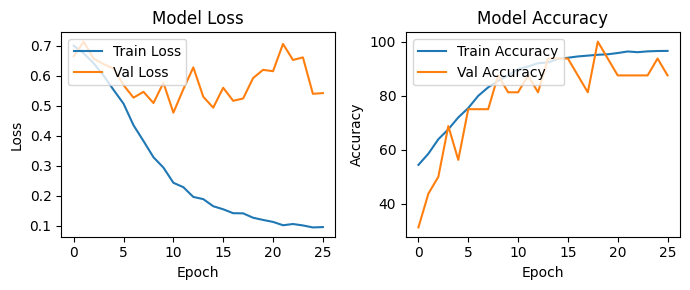

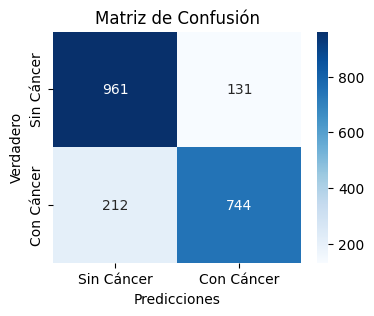

Precisión global: 83.25%
Informe y métricas de clasificación:
              precision    recall  f1-score   support

  Sin Cáncer       0.82      0.88      0.85      1092
  Con Cáncer       0.85      0.78      0.81       956

    accuracy                           0.83      2048
   macro avg       0.83      0.83      0.83      2048
weighted avg       0.83      0.83      0.83      2048

Precisión: 0.85
Sensibilidad (Recall): 0.78
F1-Score: 0.81
Accuracy: 0.83
Especificidad: 0.88


In [ ]:
graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(efficientnetManual, test_loader, transform)

In [ ]:
### INCEPTION V3
inceptionv3 = models.inception_v3(pretrained=True)
inceptionv3.fc = nn.Linear(inceptionv3.fc.in_features, 2)
inceptionv3.aux_logits = False  # Desactivamos las salidas auxiliares (usadas durante el entrenamiento inicial)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inceptionv3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(inceptionv3.parameters(), lr=0.001)

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Resize((299, 299)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

fichModelo = modelsdir + '/inceptionv3.pth'
eaStop = EarlyStopping(fichModelo, patience=15, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inceptionv3.to(device)
epochs = 50

train_loss, train_accu, val_loss, val_accu = trainModel(inceptionv3,train_loader,test_loader,criterion,optimizer,epochs,device,eaStop,transform)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 71.5MB/s]
Epoch 1/50: 100%|██████████| 619/619 [01:06<00:00,  9.28it/s]


Epoch [1/50], Train Loss: 0.705, Train Accuracy: 50.58%, Val Loss: 0.6949, Val Accuracy: 43.75%, Time: 71.18 seconds
Pérdida de validación mejorada a 0.694917. Guardando modelo...


Epoch 2/50: 100%|██████████| 619/619 [01:06<00:00,  9.37it/s]


Epoch [2/50], Train Loss: 0.700, Train Accuracy: 50.57%, Val Loss: 0.7052, Val Accuracy: 50.00%, Time: 70.42 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 3/50: 100%|██████████| 619/619 [01:05<00:00,  9.40it/s]


Epoch [3/50], Train Loss: 0.703, Train Accuracy: 51.68%, Val Loss: 0.6980, Val Accuracy: 50.00%, Time: 70.21 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 4/50: 100%|██████████| 619/619 [01:05<00:00,  9.50it/s]


Epoch [4/50], Train Loss: 0.697, Train Accuracy: 52.03%, Val Loss: 0.7251, Val Accuracy: 62.50%, Time: 69.84 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 5/50: 100%|██████████| 619/619 [01:05<00:00,  9.43it/s]


Epoch [5/50], Train Loss: 0.701, Train Accuracy: 50.91%, Val Loss: 0.7119, Val Accuracy: 62.50%, Time: 69.94 seconds
EarlyStopping no mejoró por 4 épocas


Epoch 6/50: 100%|██████████| 619/619 [01:05<00:00,  9.45it/s]


Epoch [6/50], Train Loss: 0.699, Train Accuracy: 51.01%, Val Loss: 0.7047, Val Accuracy: 56.25%, Time: 69.93 seconds
EarlyStopping no mejoró por 5 épocas


Epoch 7/50: 100%|██████████| 619/619 [01:04<00:00,  9.62it/s]


Epoch [7/50], Train Loss: 0.700, Train Accuracy: 50.03%, Val Loss: 0.7216, Val Accuracy: 56.25%, Time: 68.90 seconds
EarlyStopping no mejoró por 6 épocas


Epoch 8/50: 100%|██████████| 619/619 [01:04<00:00,  9.55it/s]


Epoch [8/50], Train Loss: 0.698, Train Accuracy: 51.17%, Val Loss: 0.6881, Val Accuracy: 62.50%, Time: 69.17 seconds
Pérdida de validación mejorada a 0.688098. Guardando modelo...


Epoch 9/50: 100%|██████████| 619/619 [01:04<00:00,  9.59it/s]


Epoch [9/50], Train Loss: 0.695, Train Accuracy: 51.68%, Val Loss: 1.2496, Val Accuracy: 43.75%, Time: 69.03 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 10/50: 100%|██████████| 619/619 [01:05<00:00,  9.52it/s]


Epoch [10/50], Train Loss: 0.695, Train Accuracy: 53.91%, Val Loss: 0.6901, Val Accuracy: 50.00%, Time: 69.52 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 11/50: 100%|██████████| 619/619 [01:05<00:00,  9.49it/s]


Epoch [11/50], Train Loss: 0.695, Train Accuracy: 54.01%, Val Loss: 0.6833, Val Accuracy: 50.00%, Time: 69.55 seconds
Pérdida de validación mejorada a 0.683294. Guardando modelo...


Epoch 12/50: 100%|██████████| 619/619 [01:04<00:00,  9.53it/s]


Epoch [12/50], Train Loss: 0.690, Train Accuracy: 55.39%, Val Loss: 0.7565, Val Accuracy: 50.00%, Time: 69.43 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 13/50: 100%|██████████| 619/619 [01:05<00:00,  9.52it/s]


Epoch [13/50], Train Loss: 0.688, Train Accuracy: 55.78%, Val Loss: 0.6820, Val Accuracy: 50.00%, Time: 69.50 seconds
Pérdida de validación mejorada a 0.682001. Guardando modelo...


Epoch 14/50: 100%|██████████| 619/619 [01:06<00:00,  9.28it/s]


Epoch [14/50], Train Loss: 0.689, Train Accuracy: 55.37%, Val Loss: 0.6852, Val Accuracy: 50.00%, Time: 71.04 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 15/50: 100%|██████████| 619/619 [01:04<00:00,  9.52it/s]


Epoch [15/50], Train Loss: 0.690, Train Accuracy: 54.61%, Val Loss: 0.6782, Val Accuracy: 56.25%, Time: 69.35 seconds
Pérdida de validación mejorada a 0.678241. Guardando modelo...


Epoch 16/50: 100%|██████████| 619/619 [01:04<00:00,  9.55it/s]


Epoch [16/50], Train Loss: 0.690, Train Accuracy: 55.49%, Val Loss: 0.6854, Val Accuracy: 50.00%, Time: 69.41 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 17/50: 100%|██████████| 619/619 [01:04<00:00,  9.59it/s]


Epoch [17/50], Train Loss: 0.687, Train Accuracy: 55.41%, Val Loss: 0.6768, Val Accuracy: 62.50%, Time: 68.87 seconds
Pérdida de validación mejorada a 0.676776. Guardando modelo...


Epoch 18/50: 100%|██████████| 619/619 [01:04<00:00,  9.58it/s]


Epoch [18/50], Train Loss: 0.687, Train Accuracy: 55.57%, Val Loss: 0.6751, Val Accuracy: 68.75%, Time: 69.03 seconds
Pérdida de validación mejorada a 0.675078. Guardando modelo...


Epoch 19/50: 100%|██████████| 619/619 [01:04<00:00,  9.61it/s]


Epoch [19/50], Train Loss: 0.691, Train Accuracy: 54.96%, Val Loss: 0.7130, Val Accuracy: 62.50%, Time: 68.79 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 20/50: 100%|██████████| 619/619 [01:04<00:00,  9.57it/s]


Epoch [20/50], Train Loss: 0.691, Train Accuracy: 54.56%, Val Loss: 0.6948, Val Accuracy: 75.00%, Time: 69.06 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 21/50: 100%|██████████| 619/619 [01:04<00:00,  9.55it/s]


Epoch [21/50], Train Loss: 0.687, Train Accuracy: 55.70%, Val Loss: 0.6885, Val Accuracy: 50.00%, Time: 69.46 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 22/50: 100%|██████████| 619/619 [01:04<00:00,  9.56it/s]


Epoch [22/50], Train Loss: 0.682, Train Accuracy: 56.81%, Val Loss: 0.6731, Val Accuracy: 56.25%, Time: 69.07 seconds
Pérdida de validación mejorada a 0.673096. Guardando modelo...


Epoch 23/50: 100%|██████████| 619/619 [01:04<00:00,  9.60it/s]


Epoch [23/50], Train Loss: 0.678, Train Accuracy: 57.14%, Val Loss: 0.6765, Val Accuracy: 68.75%, Time: 68.82 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 24/50: 100%|██████████| 619/619 [01:04<00:00,  9.56it/s]


Epoch [24/50], Train Loss: 0.678, Train Accuracy: 57.47%, Val Loss: 0.6884, Val Accuracy: 43.75%, Time: 69.39 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 25/50: 100%|██████████| 619/619 [01:04<00:00,  9.59it/s]


Epoch [25/50], Train Loss: 0.673, Train Accuracy: 58.89%, Val Loss: 0.7394, Val Accuracy: 50.00%, Time: 68.85 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 26/50: 100%|██████████| 619/619 [01:04<00:00,  9.60it/s]


Epoch [26/50], Train Loss: 0.670, Train Accuracy: 58.68%, Val Loss: 0.6692, Val Accuracy: 50.00%, Time: 68.94 seconds
Pérdida de validación mejorada a 0.669249. Guardando modelo...


Epoch 27/50: 100%|██████████| 619/619 [01:04<00:00,  9.59it/s]


Epoch [27/50], Train Loss: 0.675, Train Accuracy: 58.35%, Val Loss: 0.6777, Val Accuracy: 62.50%, Time: 69.02 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 28/50: 100%|██████████| 619/619 [01:04<00:00,  9.54it/s]


Epoch [28/50], Train Loss: 0.671, Train Accuracy: 58.92%, Val Loss: 0.6567, Val Accuracy: 62.50%, Time: 69.22 seconds
Pérdida de validación mejorada a 0.656653. Guardando modelo...


Epoch 29/50: 100%|██████████| 619/619 [01:04<00:00,  9.57it/s]


Epoch [29/50], Train Loss: 0.669, Train Accuracy: 59.51%, Val Loss: 0.6596, Val Accuracy: 56.25%, Time: 69.40 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 30/50: 100%|██████████| 619/619 [01:05<00:00,  9.48it/s]


Epoch [30/50], Train Loss: 0.666, Train Accuracy: 59.21%, Val Loss: 0.6921, Val Accuracy: 50.00%, Time: 69.71 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 31/50: 100%|██████████| 619/619 [01:04<00:00,  9.54it/s]


Epoch [31/50], Train Loss: 0.661, Train Accuracy: 60.52%, Val Loss: 1.0534, Val Accuracy: 43.75%, Time: 69.25 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 32/50: 100%|██████████| 619/619 [01:04<00:00,  9.59it/s]


Epoch [32/50], Train Loss: 0.650, Train Accuracy: 62.55%, Val Loss: 0.8124, Val Accuracy: 43.75%, Time: 69.19 seconds
EarlyStopping no mejoró por 4 épocas


Epoch 33/50: 100%|██████████| 619/619 [01:04<00:00,  9.56it/s]


Epoch [33/50], Train Loss: 0.639, Train Accuracy: 64.11%, Val Loss: 0.6519, Val Accuracy: 68.75%, Time: 69.08 seconds
Pérdida de validación mejorada a 0.651889. Guardando modelo...


Epoch 34/50: 100%|██████████| 619/619 [01:04<00:00,  9.59it/s]


Epoch [34/50], Train Loss: 0.629, Train Accuracy: 64.98%, Val Loss: 0.6828, Val Accuracy: 68.75%, Time: 68.86 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 35/50: 100%|██████████| 619/619 [01:04<00:00,  9.59it/s]


Epoch [35/50], Train Loss: 0.618, Train Accuracy: 66.25%, Val Loss: 0.6606, Val Accuracy: 62.50%, Time: 69.22 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 36/50: 100%|██████████| 619/619 [01:04<00:00,  9.61it/s]


Epoch [36/50], Train Loss: 0.603, Train Accuracy: 67.67%, Val Loss: 0.6330, Val Accuracy: 68.75%, Time: 68.68 seconds
Pérdida de validación mejorada a 0.633006. Guardando modelo...


Epoch 37/50: 100%|██████████| 619/619 [01:04<00:00,  9.59it/s]


Epoch [37/50], Train Loss: 0.580, Train Accuracy: 69.65%, Val Loss: 0.6291, Val Accuracy: 75.00%, Time: 68.87 seconds
Pérdida de validación mejorada a 0.629125. Guardando modelo...


Epoch 38/50: 100%|██████████| 619/619 [01:04<00:00,  9.59it/s]


Epoch [38/50], Train Loss: 0.559, Train Accuracy: 71.58%, Val Loss: 2.2178, Val Accuracy: 43.75%, Time: 69.10 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 39/50: 100%|██████████| 619/619 [01:04<00:00,  9.56it/s]


Epoch [39/50], Train Loss: 0.531, Train Accuracy: 73.49%, Val Loss: 0.6098, Val Accuracy: 87.50%, Time: 69.07 seconds
Pérdida de validación mejorada a 0.609841. Guardando modelo...


Epoch 40/50: 100%|██████████| 619/619 [01:04<00:00,  9.53it/s]


Epoch [40/50], Train Loss: 0.498, Train Accuracy: 75.96%, Val Loss: 0.6538, Val Accuracy: 56.25%, Time: 69.44 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 41/50: 100%|██████████| 619/619 [01:04<00:00,  9.58it/s]


Epoch [41/50], Train Loss: 0.458, Train Accuracy: 78.55%, Val Loss: 0.6103, Val Accuracy: 93.75%, Time: 68.97 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 42/50: 100%|██████████| 619/619 [01:04<00:00,  9.59it/s]


Epoch [42/50], Train Loss: 0.412, Train Accuracy: 81.53%, Val Loss: 0.5548, Val Accuracy: 75.00%, Time: 68.91 seconds
Pérdida de validación mejorada a 0.554844. Guardando modelo...


Epoch 43/50: 100%|██████████| 619/619 [01:04<00:00,  9.56it/s]


Epoch [43/50], Train Loss: 0.360, Train Accuracy: 84.52%, Val Loss: 0.6542, Val Accuracy: 81.25%, Time: 69.36 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 44/50: 100%|██████████| 619/619 [01:05<00:00,  9.47it/s]


Epoch [44/50], Train Loss: 0.330, Train Accuracy: 85.72%, Val Loss: 0.8080, Val Accuracy: 68.75%, Time: 69.74 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 45/50: 100%|██████████| 619/619 [01:04<00:00,  9.65it/s]


Epoch [45/50], Train Loss: 0.284, Train Accuracy: 88.18%, Val Loss: 0.5610, Val Accuracy: 87.50%, Time: 68.48 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 46/50: 100%|██████████| 619/619 [01:04<00:00,  9.55it/s]


Epoch [46/50], Train Loss: 0.244, Train Accuracy: 90.06%, Val Loss: 0.6036, Val Accuracy: 87.50%, Time: 69.34 seconds
EarlyStopping no mejoró por 4 épocas


Epoch 47/50: 100%|██████████| 619/619 [01:04<00:00,  9.55it/s]


Epoch [47/50], Train Loss: 0.218, Train Accuracy: 91.11%, Val Loss: 0.5941, Val Accuracy: 93.75%, Time: 69.10 seconds
EarlyStopping no mejoró por 5 épocas


Epoch 48/50: 100%|██████████| 619/619 [01:04<00:00,  9.57it/s]


Epoch [48/50], Train Loss: 0.189, Train Accuracy: 92.65%, Val Loss: 0.6056, Val Accuracy: 93.75%, Time: 69.15 seconds
EarlyStopping no mejoró por 6 épocas


Epoch 49/50: 100%|██████████| 619/619 [01:05<00:00,  9.39it/s]


Epoch [49/50], Train Loss: 0.179, Train Accuracy: 93.20%, Val Loss: 0.7409, Val Accuracy: 87.50%, Time: 70.64 seconds
EarlyStopping no mejoró por 7 épocas


Epoch 50/50: 100%|██████████| 619/619 [01:04<00:00,  9.54it/s]


Epoch [50/50], Train Loss: 0.163, Train Accuracy: 93.65%, Val Loss: 1.0571, Val Accuracy: 81.25%, Time: 69.11 seconds
EarlyStopping no mejoró por 8 épocas


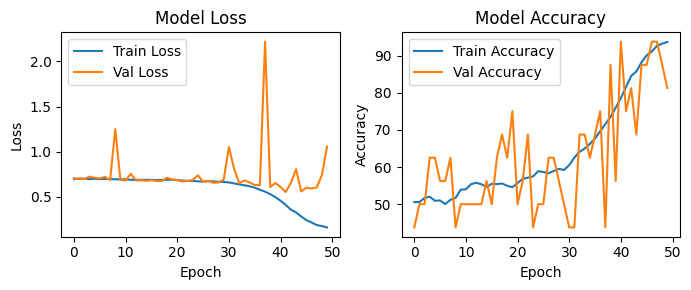

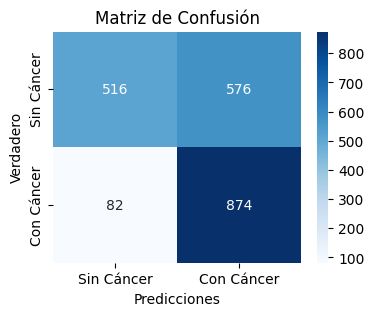

Precisión global: 67.87%
Informe y métricas de clasificación:
              precision    recall  f1-score   support

  Sin Cáncer       0.86      0.47      0.61      1092
  Con Cáncer       0.60      0.91      0.73       956

    accuracy                           0.68      2048
   macro avg       0.73      0.69      0.67      2048
weighted avg       0.74      0.68      0.66      2048

Precisión: 0.60
Sensibilidad (Recall): 0.91
F1-Score: 0.73
Accuracy: 0.68
Especificidad: 0.47


In [ ]:
models_list.append("inceptionv3");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(inceptionv3, test_loader, transform)

In [ ]:
## DENSENET 121
densenet121 = models.densenet121(pretrained=False)
num_classes = 2
densenet121.classifier = nn.Linear(densenet121.classifier.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet121.to(device)

# Definir las transformaciones para DenseNet121
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet121.parameters(), lr=0.001)
fichModelo = modelsdir + '/densenet121.pth'
eaStop = EarlyStopping(fichModelo, patience=20, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet121.to(device)
epochs = 50

train_loss, train_accu, val_loss, val_accu = trainModel(densenet121,train_loader,test_loader,criterion,optimizer,epochs,device,eaStop,transform)

Epoch 1/50: 100%|██████████| 619/619 [01:41<00:00,  6.08it/s]


Epoch [1/50], Train Loss: 0.699, Train Accuracy: 53.11%, Val Loss: 6.9148, Val Accuracy: 43.75%, Time: 108.40 seconds
Pérdida de validación mejorada a 6.914833. Guardando modelo...


Epoch 2/50: 100%|██████████| 619/619 [01:42<00:00,  6.02it/s]


Epoch [2/50], Train Loss: 0.683, Train Accuracy: 56.38%, Val Loss: 0.7941, Val Accuracy: 43.75%, Time: 109.57 seconds
Pérdida de validación mejorada a 0.794104. Guardando modelo...


Epoch 3/50: 100%|██████████| 619/619 [01:43<00:00,  5.97it/s]


Epoch [3/50], Train Loss: 0.676, Train Accuracy: 57.90%, Val Loss: 0.6987, Val Accuracy: 43.75%, Time: 110.37 seconds
Pérdida de validación mejorada a 0.698748. Guardando modelo...


Epoch 4/50: 100%|██████████| 619/619 [01:44<00:00,  5.95it/s]


Epoch [4/50], Train Loss: 0.671, Train Accuracy: 58.31%, Val Loss: 3.0450, Val Accuracy: 43.75%, Time: 110.76 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 5/50: 100%|██████████| 619/619 [01:43<00:00,  5.96it/s]


Epoch [5/50], Train Loss: 0.668, Train Accuracy: 59.56%, Val Loss: 0.8316, Val Accuracy: 43.75%, Time: 110.56 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 6/50: 100%|██████████| 619/619 [01:43<00:00,  5.96it/s]


Epoch [6/50], Train Loss: 0.661, Train Accuracy: 60.03%, Val Loss: 0.6780, Val Accuracy: 50.00%, Time: 110.65 seconds
Pérdida de validación mejorada a 0.678000. Guardando modelo...


Epoch 7/50: 100%|██████████| 619/619 [01:43<00:00,  5.96it/s]


Epoch [7/50], Train Loss: 0.662, Train Accuracy: 60.41%, Val Loss: 0.6764, Val Accuracy: 62.50%, Time: 110.64 seconds
Pérdida de validación mejorada a 0.676402. Guardando modelo...


Epoch 8/50: 100%|██████████| 619/619 [01:43<00:00,  5.96it/s]


Epoch [8/50], Train Loss: 0.659, Train Accuracy: 60.34%, Val Loss: 0.7059, Val Accuracy: 50.00%, Time: 110.59 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 9/50: 100%|██████████| 619/619 [01:43<00:00,  5.95it/s]


Epoch [9/50], Train Loss: 0.653, Train Accuracy: 61.00%, Val Loss: 7.2668, Val Accuracy: 43.75%, Time: 110.67 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 10/50: 100%|██████████| 619/619 [01:44<00:00,  5.94it/s]


Epoch [10/50], Train Loss: 0.647, Train Accuracy: 61.49%, Val Loss: 4.6059, Val Accuracy: 43.75%, Time: 110.92 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 11/50: 100%|██████████| 619/619 [01:44<00:00,  5.94it/s]


Epoch [11/50], Train Loss: 0.647, Train Accuracy: 61.55%, Val Loss: 0.6985, Val Accuracy: 56.25%, Time: 110.93 seconds
EarlyStopping no mejoró por 4 épocas


Epoch 12/50: 100%|██████████| 619/619 [01:44<00:00,  5.94it/s]


Epoch [12/50], Train Loss: 0.638, Train Accuracy: 62.91%, Val Loss: 1.7283, Val Accuracy: 43.75%, Time: 110.82 seconds
EarlyStopping no mejoró por 5 épocas


Epoch 13/50: 100%|██████████| 619/619 [01:43<00:00,  5.96it/s]


Epoch [13/50], Train Loss: 0.632, Train Accuracy: 63.93%, Val Loss: 0.6599, Val Accuracy: 56.25%, Time: 110.58 seconds
Pérdida de validación mejorada a 0.659894. Guardando modelo...


Epoch 14/50: 100%|██████████| 619/619 [01:44<00:00,  5.94it/s]


Epoch [14/50], Train Loss: 0.628, Train Accuracy: 64.17%, Val Loss: 0.6755, Val Accuracy: 62.50%, Time: 110.97 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 15/50: 100%|██████████| 619/619 [01:44<00:00,  5.95it/s]


Epoch [15/50], Train Loss: 0.622, Train Accuracy: 64.78%, Val Loss: 5.9694, Val Accuracy: 43.75%, Time: 110.78 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 16/50: 100%|██████████| 619/619 [01:44<00:00,  5.94it/s]


Epoch [16/50], Train Loss: 0.614, Train Accuracy: 65.71%, Val Loss: 0.6543, Val Accuracy: 56.25%, Time: 111.04 seconds
Pérdida de validación mejorada a 0.654253. Guardando modelo...


Epoch 17/50: 100%|██████████| 619/619 [01:44<00:00,  5.94it/s]


Epoch [17/50], Train Loss: 0.602, Train Accuracy: 66.74%, Val Loss: 0.6819, Val Accuracy: 50.00%, Time: 110.98 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 18/50: 100%|██████████| 619/619 [01:43<00:00,  5.96it/s]


Epoch [18/50], Train Loss: 0.591, Train Accuracy: 67.65%, Val Loss: 0.6406, Val Accuracy: 56.25%, Time: 110.67 seconds
Pérdida de validación mejorada a 0.640609. Guardando modelo...


Epoch 19/50: 100%|██████████| 619/619 [01:43<00:00,  5.95it/s]


Epoch [19/50], Train Loss: 0.573, Train Accuracy: 70.14%, Val Loss: 0.6597, Val Accuracy: 56.25%, Time: 110.62 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 20/50: 100%|██████████| 619/619 [01:44<00:00,  5.95it/s]


Epoch [20/50], Train Loss: 0.548, Train Accuracy: 72.17%, Val Loss: 0.6686, Val Accuracy: 56.25%, Time: 110.81 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 21/50: 100%|██████████| 619/619 [01:44<00:00,  5.94it/s]


Epoch [21/50], Train Loss: 0.525, Train Accuracy: 73.90%, Val Loss: 2.6681, Val Accuracy: 43.75%, Time: 110.94 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 22/50: 100%|██████████| 619/619 [01:44<00:00,  5.93it/s]


Epoch [22/50], Train Loss: 0.488, Train Accuracy: 76.58%, Val Loss: 0.6208, Val Accuracy: 62.50%, Time: 111.06 seconds
Pérdida de validación mejorada a 0.620810. Guardando modelo...


Epoch 23/50: 100%|██████████| 619/619 [01:44<00:00,  5.94it/s]


Epoch [23/50], Train Loss: 0.453, Train Accuracy: 79.01%, Val Loss: 0.6285, Val Accuracy: 75.00%, Time: 110.89 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 24/50: 100%|██████████| 619/619 [01:44<00:00,  5.94it/s]


Epoch [24/50], Train Loss: 0.400, Train Accuracy: 81.94%, Val Loss: 0.6012, Val Accuracy: 56.25%, Time: 110.97 seconds
Pérdida de validación mejorada a 0.601245. Guardando modelo...


Epoch 25/50: 100%|██████████| 619/619 [01:44<00:00,  5.94it/s]


Epoch [25/50], Train Loss: 0.366, Train Accuracy: 84.32%, Val Loss: 6.4119, Val Accuracy: 43.75%, Time: 110.87 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 26/50: 100%|██████████| 619/619 [01:44<00:00,  5.94it/s]


Epoch [26/50], Train Loss: 0.311, Train Accuracy: 86.95%, Val Loss: 3.5239, Val Accuracy: 43.75%, Time: 110.92 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 27/50: 100%|██████████| 619/619 [01:44<00:00,  5.95it/s]


Epoch [27/50], Train Loss: 0.273, Train Accuracy: 88.53%, Val Loss: 0.8124, Val Accuracy: 68.75%, Time: 110.69 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 28/50: 100%|██████████| 619/619 [01:43<00:00,  5.97it/s]


Epoch [28/50], Train Loss: 0.232, Train Accuracy: 90.56%, Val Loss: 0.5885, Val Accuracy: 75.00%, Time: 110.29 seconds
Pérdida de validación mejorada a 0.588535. Guardando modelo...


Epoch 29/50: 100%|██████████| 619/619 [01:43<00:00,  5.96it/s]


Epoch [29/50], Train Loss: 0.199, Train Accuracy: 92.30%, Val Loss: 1.2667, Val Accuracy: 62.50%, Time: 110.60 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 30/50: 100%|██████████| 619/619 [01:44<00:00,  5.95it/s]


Epoch [30/50], Train Loss: 0.179, Train Accuracy: 92.72%, Val Loss: 0.7736, Val Accuracy: 75.00%, Time: 110.75 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 31/50: 100%|██████████| 619/619 [01:44<00:00,  5.94it/s]


Epoch [31/50], Train Loss: 0.153, Train Accuracy: 94.06%, Val Loss: 0.5894, Val Accuracy: 87.50%, Time: 110.87 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 32/50: 100%|██████████| 619/619 [01:44<00:00,  5.95it/s]


Epoch [32/50], Train Loss: 0.140, Train Accuracy: 94.77%, Val Loss: 0.9436, Val Accuracy: 75.00%, Time: 110.78 seconds
EarlyStopping no mejoró por 4 épocas


Epoch 33/50: 100%|██████████| 619/619 [01:43<00:00,  5.96it/s]


Epoch [33/50], Train Loss: 0.135, Train Accuracy: 94.84%, Val Loss: 0.7688, Val Accuracy: 87.50%, Time: 110.59 seconds
EarlyStopping no mejoró por 5 épocas


Epoch 34/50: 100%|██████████| 619/619 [01:43<00:00,  5.96it/s]


Epoch [34/50], Train Loss: 0.109, Train Accuracy: 95.95%, Val Loss: 2.2824, Val Accuracy: 62.50%, Time: 110.63 seconds
EarlyStopping no mejoró por 6 épocas


Epoch 35/50: 100%|██████████| 619/619 [01:43<00:00,  5.95it/s]


Epoch [35/50], Train Loss: 0.108, Train Accuracy: 96.05%, Val Loss: 0.8102, Val Accuracy: 81.25%, Time: 110.69 seconds
EarlyStopping no mejoró por 7 épocas


Epoch 36/50: 100%|██████████| 619/619 [01:44<00:00,  5.94it/s]


Epoch [36/50], Train Loss: 0.091, Train Accuracy: 96.78%, Val Loss: 8.5524, Val Accuracy: 43.75%, Time: 110.87 seconds
EarlyStopping no mejoró por 8 épocas


Epoch 37/50: 100%|██████████| 619/619 [01:44<00:00,  5.94it/s]


Epoch [37/50], Train Loss: 0.081, Train Accuracy: 97.08%, Val Loss: 0.6744, Val Accuracy: 87.50%, Time: 110.95 seconds
EarlyStopping no mejoró por 9 épocas


Epoch 38/50: 100%|██████████| 619/619 [01:44<00:00,  5.95it/s]


Epoch [38/50], Train Loss: 0.095, Train Accuracy: 96.79%, Val Loss: 0.8555, Val Accuracy: 93.75%, Time: 110.79 seconds
EarlyStopping no mejoró por 10 épocas


Epoch 39/50: 100%|██████████| 619/619 [01:44<00:00,  5.95it/s]


Epoch [39/50], Train Loss: 0.075, Train Accuracy: 97.43%, Val Loss: 2.6868, Val Accuracy: 68.75%, Time: 110.82 seconds
EarlyStopping no mejoró por 11 épocas


Epoch 40/50: 100%|██████████| 619/619 [01:44<00:00,  5.93it/s]


Epoch [40/50], Train Loss: 0.078, Train Accuracy: 97.12%, Val Loss: 3.7973, Val Accuracy: 50.00%, Time: 111.11 seconds
EarlyStopping no mejoró por 12 épocas


Epoch 41/50: 100%|██████████| 619/619 [01:44<00:00,  5.95it/s]


Epoch [41/50], Train Loss: 0.070, Train Accuracy: 97.48%, Val Loss: 14.8158, Val Accuracy: 43.75%, Time: 110.85 seconds
EarlyStopping no mejoró por 13 épocas


Epoch 42/50: 100%|██████████| 619/619 [01:44<00:00,  5.94it/s]


Epoch [42/50], Train Loss: 0.083, Train Accuracy: 97.14%, Val Loss: 0.6523, Val Accuracy: 93.75%, Time: 110.87 seconds
EarlyStopping no mejoró por 14 épocas


Epoch 43/50: 100%|██████████| 619/619 [01:44<00:00,  5.94it/s]


Epoch [43/50], Train Loss: 0.050, Train Accuracy: 98.43%, Val Loss: 9.9691, Val Accuracy: 43.75%, Time: 110.92 seconds
EarlyStopping no mejoró por 15 épocas


Epoch 44/50: 100%|██████████| 619/619 [01:43<00:00,  5.95it/s]


Epoch [44/50], Train Loss: 0.049, Train Accuracy: 98.19%, Val Loss: 1.3725, Val Accuracy: 81.25%, Time: 110.75 seconds
EarlyStopping no mejoró por 16 épocas


Epoch 45/50: 100%|██████████| 619/619 [01:44<00:00,  5.93it/s]


Epoch [45/50], Train Loss: 0.067, Train Accuracy: 97.58%, Val Loss: 0.8136, Val Accuracy: 87.50%, Time: 111.10 seconds
EarlyStopping no mejoró por 17 épocas


Epoch 46/50: 100%|██████████| 619/619 [01:44<00:00,  5.94it/s]


Epoch [46/50], Train Loss: 0.060, Train Accuracy: 97.82%, Val Loss: 0.8407, Val Accuracy: 81.25%, Time: 111.01 seconds
EarlyStopping no mejoró por 18 épocas


Epoch 47/50: 100%|██████████| 619/619 [01:44<00:00,  5.95it/s]


Epoch [47/50], Train Loss: 0.058, Train Accuracy: 98.10%, Val Loss: 0.7236, Val Accuracy: 87.50%, Time: 110.74 seconds
EarlyStopping no mejoró por 19 épocas


Epoch 48/50: 100%|██████████| 619/619 [01:44<00:00,  5.95it/s]


Epoch [48/50], Train Loss: 0.059, Train Accuracy: 97.98%, Val Loss: 0.5411, Val Accuracy: 93.75%, Time: 110.80 seconds
Pérdida de validación mejorada a 0.541137. Guardando modelo...


Epoch 49/50: 100%|██████████| 619/619 [01:43<00:00,  5.95it/s]


Epoch [49/50], Train Loss: 0.050, Train Accuracy: 98.30%, Val Loss: 1.1661, Val Accuracy: 81.25%, Time: 110.66 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 50/50: 100%|██████████| 619/619 [01:44<00:00,  5.95it/s]


Epoch [50/50], Train Loss: 0.050, Train Accuracy: 98.20%, Val Loss: 0.6851, Val Accuracy: 87.50%, Time: 110.84 seconds
EarlyStopping no mejoró por 2 épocas


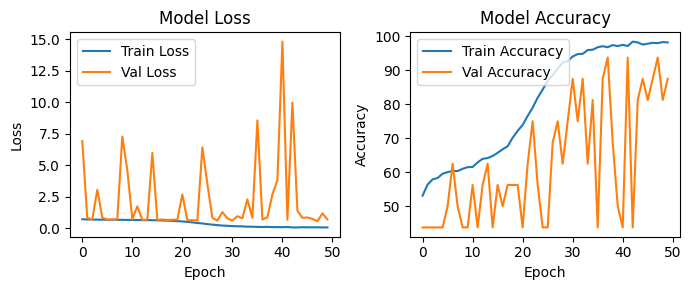

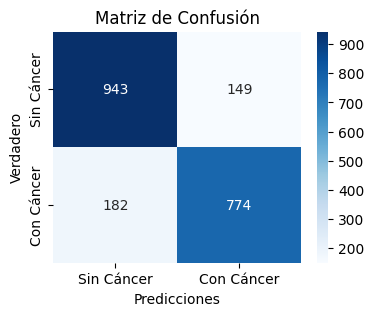

Precisión global: 83.84%
Informe y métricas de clasificación:
              precision    recall  f1-score   support

  Sin Cáncer       0.84      0.86      0.85      1092
  Con Cáncer       0.84      0.81      0.82       956

    accuracy                           0.84      2048
   macro avg       0.84      0.84      0.84      2048
weighted avg       0.84      0.84      0.84      2048

Precisión: 0.84
Sensibilidad (Recall): 0.81
F1-Score: 0.82
Accuracy: 0.84
Especificidad: 0.86


In [ ]:
models_list.append("densenet121");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(densenet121, test_loader, transform)

In [ ]:
## DENSENET 121 con pesos PRECARGADOS
densenet121Pre = models.densenet121(weights='DenseNet121_Weights.DEFAULT')
num_classes = 2
densenet121Pre.classifier = nn.Linear(densenet121Pre.classifier.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet121Pre.to(device)

# Definir las transformaciones para DenseNet121
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet121Pre.parameters(), lr=0.001)
fichModelo = modelsdir + '/densenet121Pre.pth'
eaStop = EarlyStopping(fichModelo, patience=20, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet121Pre.to(device)
epochs = 30

train_loss, train_accu, val_loss, val_accu = trainModel(densenet121Pre,train_loader,test_loader,criterion,optimizer,epochs,device,eaStop,transform)

Epoch 1/30: 100%|██████████| 619/619 [01:49<00:00,  5.68it/s]


Epoch [1/30], Train Loss: 0.719, Train Accuracy: 51.44%, Val Loss: 0.6911, Val Accuracy: 56.25%, Time: 116.57 seconds
Pérdida de validación mejorada a 0.691112. Guardando modelo...


Epoch 2/30: 100%|██████████| 619/619 [01:49<00:00,  5.64it/s]


Epoch [2/30], Train Loss: 0.707, Train Accuracy: 52.00%, Val Loss: 0.6896, Val Accuracy: 56.25%, Time: 116.76 seconds
Pérdida de validación mejorada a 0.689572. Guardando modelo...


Epoch 3/30: 100%|██████████| 619/619 [01:48<00:00,  5.71it/s]


Epoch [3/30], Train Loss: 0.695, Train Accuracy: 54.42%, Val Loss: 0.8689, Val Accuracy: 43.75%, Time: 115.57 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 4/30: 100%|██████████| 619/619 [01:48<00:00,  5.71it/s]


Epoch [4/30], Train Loss: 0.693, Train Accuracy: 54.66%, Val Loss: 0.6829, Val Accuracy: 62.50%, Time: 115.58 seconds
Pérdida de validación mejorada a 0.682900. Guardando modelo...


Epoch 5/30: 100%|██████████| 619/619 [01:48<00:00,  5.68it/s]


Epoch [5/30], Train Loss: 0.682, Train Accuracy: 57.30%, Val Loss: 0.6748, Val Accuracy: 56.25%, Time: 116.11 seconds
Pérdida de validación mejorada a 0.674839. Guardando modelo...


Epoch 6/30: 100%|██████████| 619/619 [01:49<00:00,  5.67it/s]


Epoch [6/30], Train Loss: 0.679, Train Accuracy: 57.96%, Val Loss: 0.6767, Val Accuracy: 50.00%, Time: 116.38 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 7/30: 100%|██████████| 619/619 [01:49<00:00,  5.68it/s]


Epoch [7/30], Train Loss: 0.670, Train Accuracy: 59.77%, Val Loss: 0.7601, Val Accuracy: 43.75%, Time: 116.20 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 8/30: 100%|██████████| 619/619 [01:49<00:00,  5.66it/s]


Epoch [8/30], Train Loss: 0.666, Train Accuracy: 60.24%, Val Loss: 0.8991, Val Accuracy: 43.75%, Time: 116.55 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 9/30: 100%|██████████| 619/619 [01:48<00:00,  5.71it/s]


Epoch [9/30], Train Loss: 0.661, Train Accuracy: 60.54%, Val Loss: 0.6736, Val Accuracy: 62.50%, Time: 115.47 seconds
Pérdida de validación mejorada a 0.673638. Guardando modelo...


Epoch 10/30: 100%|██████████| 619/619 [01:48<00:00,  5.73it/s]


Epoch [10/30], Train Loss: 0.658, Train Accuracy: 60.71%, Val Loss: 0.6548, Val Accuracy: 43.75%, Time: 115.14 seconds
Pérdida de validación mejorada a 0.654826. Guardando modelo...


Epoch 11/30: 100%|██████████| 619/619 [01:48<00:00,  5.72it/s]


Epoch [11/30], Train Loss: 0.645, Train Accuracy: 62.47%, Val Loss: 0.6861, Val Accuracy: 37.50%, Time: 115.17 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 12/30: 100%|██████████| 619/619 [01:47<00:00,  5.74it/s]


Epoch [12/30], Train Loss: 0.641, Train Accuracy: 63.18%, Val Loss: 0.6506, Val Accuracy: 56.25%, Time: 114.88 seconds
Pérdida de validación mejorada a 0.650599. Guardando modelo...


Epoch 13/30: 100%|██████████| 619/619 [01:47<00:00,  5.73it/s]


Epoch [13/30], Train Loss: 0.632, Train Accuracy: 64.19%, Val Loss: 0.6756, Val Accuracy: 62.50%, Time: 115.01 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 14/30: 100%|██████████| 619/619 [01:48<00:00,  5.72it/s]


Epoch [14/30], Train Loss: 0.624, Train Accuracy: 65.02%, Val Loss: 1.0687, Val Accuracy: 43.75%, Time: 115.30 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 15/30: 100%|██████████| 619/619 [01:47<00:00,  5.74it/s]


Epoch [15/30], Train Loss: 0.617, Train Accuracy: 65.84%, Val Loss: 1.7352, Val Accuracy: 43.75%, Time: 115.02 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 16/30: 100%|██████████| 619/619 [01:48<00:00,  5.72it/s]


Epoch [16/30], Train Loss: 0.608, Train Accuracy: 66.64%, Val Loss: 0.6885, Val Accuracy: 43.75%, Time: 115.45 seconds
EarlyStopping no mejoró por 4 épocas


Epoch 17/30: 100%|██████████| 619/619 [01:48<00:00,  5.73it/s]


Epoch [17/30], Train Loss: 0.593, Train Accuracy: 68.76%, Val Loss: 0.6314, Val Accuracy: 43.75%, Time: 115.11 seconds
Pérdida de validación mejorada a 0.631355. Guardando modelo...


Epoch 18/30: 100%|██████████| 619/619 [01:47<00:00,  5.74it/s]


Epoch [18/30], Train Loss: 0.577, Train Accuracy: 69.70%, Val Loss: 0.6804, Val Accuracy: 56.25%, Time: 114.97 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 19/30: 100%|██████████| 619/619 [01:48<00:00,  5.70it/s]


Epoch [19/30], Train Loss: 0.556, Train Accuracy: 71.58%, Val Loss: 0.9047, Val Accuracy: 56.25%, Time: 115.59 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 20/30: 100%|██████████| 619/619 [01:47<00:00,  5.74it/s]


Epoch [20/30], Train Loss: 0.531, Train Accuracy: 73.61%, Val Loss: 0.6054, Val Accuracy: 68.75%, Time: 114.87 seconds
Pérdida de validación mejorada a 0.605389. Guardando modelo...


Epoch 21/30: 100%|██████████| 619/619 [01:47<00:00,  5.74it/s]


Epoch [21/30], Train Loss: 0.498, Train Accuracy: 75.75%, Val Loss: 0.6722, Val Accuracy: 43.75%, Time: 115.06 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 22/30: 100%|██████████| 619/619 [01:48<00:00,  5.72it/s]


Epoch [22/30], Train Loss: 0.462, Train Accuracy: 78.12%, Val Loss: 0.6117, Val Accuracy: 68.75%, Time: 115.31 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 23/30: 100%|██████████| 619/619 [01:47<00:00,  5.75it/s]


Epoch [23/30], Train Loss: 0.427, Train Accuracy: 80.65%, Val Loss: 0.5840, Val Accuracy: 62.50%, Time: 114.81 seconds
Pérdida de validación mejorada a 0.584044. Guardando modelo...


Epoch 24/30: 100%|██████████| 619/619 [01:48<00:00,  5.73it/s]


Epoch [24/30], Train Loss: 0.387, Train Accuracy: 82.59%, Val Loss: 0.5740, Val Accuracy: 75.00%, Time: 115.11 seconds
Pérdida de validación mejorada a 0.574025. Guardando modelo...


Epoch 25/30: 100%|██████████| 619/619 [01:48<00:00,  5.70it/s]


Epoch [25/30], Train Loss: 0.347, Train Accuracy: 84.79%, Val Loss: 0.9834, Val Accuracy: 56.25%, Time: 115.78 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 26/30: 100%|██████████| 619/619 [01:48<00:00,  5.72it/s]


Epoch [26/30], Train Loss: 0.304, Train Accuracy: 86.96%, Val Loss: 0.6092, Val Accuracy: 81.25%, Time: 115.34 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 27/30: 100%|██████████| 619/619 [01:48<00:00,  5.71it/s]


Epoch [27/30], Train Loss: 0.274, Train Accuracy: 88.42%, Val Loss: 0.5415, Val Accuracy: 68.75%, Time: 115.62 seconds
Pérdida de validación mejorada a 0.541490. Guardando modelo...


Epoch 28/30: 100%|██████████| 619/619 [01:48<00:00,  5.72it/s]


Epoch [28/30], Train Loss: 0.244, Train Accuracy: 90.24%, Val Loss: 1.3094, Val Accuracy: 50.00%, Time: 115.60 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 29/30: 100%|██████████| 619/619 [01:48<00:00,  5.73it/s]


Epoch [29/30], Train Loss: 0.209, Train Accuracy: 91.54%, Val Loss: 0.6662, Val Accuracy: 68.75%, Time: 115.16 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 30/30: 100%|██████████| 619/619 [01:48<00:00,  5.73it/s]


Epoch [30/30], Train Loss: 0.198, Train Accuracy: 91.97%, Val Loss: 0.5868, Val Accuracy: 75.00%, Time: 115.37 seconds
EarlyStopping no mejoró por 3 épocas


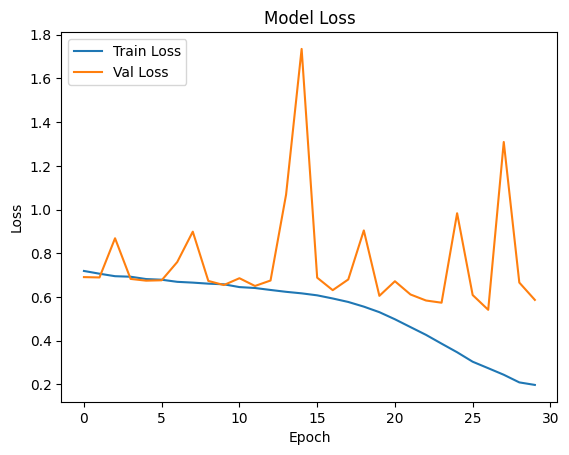

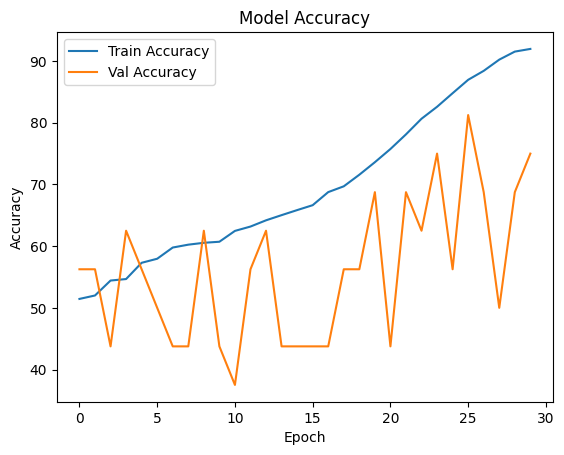

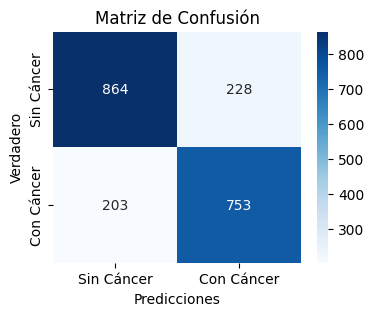

Precisión global: 78.96%
Informe y métricas de clasificación:
              precision    recall  f1-score   support

  Sin Cáncer       0.81      0.79      0.80      1092
  Con Cáncer       0.77      0.79      0.78       956

    accuracy                           0.79      2048
   macro avg       0.79      0.79      0.79      2048
weighted avg       0.79      0.79      0.79      2048

Precisión: 0.77
Sensibilidad (Recall): 0.79
F1-Score: 0.78
Accuracy: 0.79
Especificidad: 0.79


In [ ]:
models_list.append("densenet121Pre");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(densenet121Pre, test_loader, transform)

In [ ]:
## VGG16
vgg16bn = models.vgg16_bn(pretrained=False)
num_classes = 2
vgg16bn.classifier[6] = nn.Linear(vgg16bn.classifier[6].in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16bn.to(device)

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización estándar para modelos preentrenados
])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16bn.parameters(), lr=0.001)
fichModelo = modelsdir + '/vgg16bn.pth'
eaStop = EarlyStopping(fichModelo, patience=20, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16bn.to(device)
epochs = 30

train_loss, train_accu, val_loss, val_accu = trainModel(vgg16bn,train_loader,test_loader,criterion,optimizer,epochs,device,eaStop,transform)

Epoch 1/30: 100%|██████████| 619/619 [03:09<00:00,  3.27it/s]


Epoch [1/30], Train Loss: 1.170, Train Accuracy: 49.29%, Val Loss: 0.6917, Val Accuracy: 56.25%, Time: 200.88 seconds
Pérdida de validación mejorada a 0.691704. Guardando modelo...


Epoch 2/30: 100%|██████████| 619/619 [03:04<00:00,  3.35it/s]


Epoch [2/30], Train Loss: 0.694, Train Accuracy: 50.21%, Val Loss: 0.6926, Val Accuracy: 56.25%, Time: 196.40 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 3/30: 100%|██████████| 619/619 [03:04<00:00,  3.36it/s]


Epoch [3/30], Train Loss: 0.693, Train Accuracy: 50.24%, Val Loss: 0.6942, Val Accuracy: 43.75%, Time: 195.65 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 4/30: 100%|██████████| 619/619 [03:03<00:00,  3.37it/s]


Epoch [4/30], Train Loss: 0.693, Train Accuracy: 50.23%, Val Loss: 0.6951, Val Accuracy: 43.75%, Time: 195.54 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 5/30: 100%|██████████| 619/619 [03:04<00:00,  3.36it/s]


Epoch [5/30], Train Loss: 0.693, Train Accuracy: 50.35%, Val Loss: 0.6926, Val Accuracy: 56.25%, Time: 195.59 seconds
EarlyStopping no mejoró por 4 épocas


Epoch 6/30: 100%|██████████| 619/619 [03:03<00:00,  3.37it/s]


Epoch [6/30], Train Loss: 0.694, Train Accuracy: 49.13%, Val Loss: 0.6929, Val Accuracy: 56.25%, Time: 195.29 seconds
EarlyStopping no mejoró por 5 épocas


Epoch 7/30: 100%|██████████| 619/619 [03:03<00:00,  3.37it/s]


Epoch [7/30], Train Loss: 0.694, Train Accuracy: 49.56%, Val Loss: 0.6930, Val Accuracy: 56.25%, Time: 195.34 seconds
EarlyStopping no mejoró por 6 épocas


Epoch 8/30: 100%|██████████| 619/619 [03:05<00:00,  3.34it/s]


Epoch [8/30], Train Loss: 0.693, Train Accuracy: 50.22%, Val Loss: 0.6935, Val Accuracy: 43.75%, Time: 196.54 seconds
EarlyStopping no mejoró por 7 épocas


Epoch 9/30: 100%|██████████| 619/619 [03:03<00:00,  3.37it/s]


Epoch [9/30], Train Loss: 0.694, Train Accuracy: 49.39%, Val Loss: 0.6934, Val Accuracy: 43.75%, Time: 195.45 seconds
EarlyStopping no mejoró por 8 épocas


Epoch 10/30: 100%|██████████| 619/619 [03:03<00:00,  3.37it/s]


Epoch [10/30], Train Loss: 0.693, Train Accuracy: 49.91%, Val Loss: 0.6940, Val Accuracy: 43.75%, Time: 195.20 seconds
EarlyStopping no mejoró por 9 épocas


Epoch 11/30: 100%|██████████| 619/619 [03:05<00:00,  3.33it/s]


Epoch [11/30], Train Loss: 1.747, Train Accuracy: 50.30%, Val Loss: 0.7940, Val Accuracy: 56.25%, Time: 197.21 seconds
EarlyStopping no mejoró por 10 épocas


Epoch 12/30: 100%|██████████| 619/619 [03:07<00:00,  3.31it/s]


Epoch [12/30], Train Loss: 0.713, Train Accuracy: 50.48%, Val Loss: 0.6954, Val Accuracy: 43.75%, Time: 198.70 seconds
EarlyStopping no mejoró por 11 épocas


Epoch 13/30: 100%|██████████| 619/619 [03:06<00:00,  3.31it/s]


Epoch [13/30], Train Loss: 0.694, Train Accuracy: 51.55%, Val Loss: 0.6934, Val Accuracy: 56.25%, Time: 198.53 seconds
EarlyStopping no mejoró por 12 épocas


Epoch 14/30: 100%|██████████| 619/619 [03:06<00:00,  3.31it/s]


Epoch [14/30], Train Loss: 0.692, Train Accuracy: 52.35%, Val Loss: 0.7107, Val Accuracy: 62.50%, Time: 198.40 seconds
EarlyStopping no mejoró por 13 épocas


Epoch 15/30: 100%|██████████| 619/619 [03:07<00:00,  3.31it/s]


Epoch [15/30], Train Loss: 0.690, Train Accuracy: 53.09%, Val Loss: 0.7072, Val Accuracy: 43.75%, Time: 198.59 seconds
EarlyStopping no mejoró por 14 épocas


Epoch 16/30: 100%|██████████| 619/619 [03:07<00:00,  3.31it/s]


Epoch [16/30], Train Loss: 0.698, Train Accuracy: 53.28%, Val Loss: 0.7031, Val Accuracy: 43.75%, Time: 198.74 seconds
EarlyStopping no mejoró por 15 épocas


Epoch 17/30: 100%|██████████| 619/619 [03:07<00:00,  3.31it/s]


Epoch [17/30], Train Loss: 0.690, Train Accuracy: 53.46%, Val Loss: 0.6924, Val Accuracy: 62.50%, Time: 198.68 seconds
EarlyStopping no mejoró por 16 épocas


Epoch 18/30: 100%|██████████| 619/619 [03:07<00:00,  3.31it/s]


Epoch [18/30], Train Loss: 0.692, Train Accuracy: 52.93%, Val Loss: 0.6917, Val Accuracy: 75.00%, Time: 198.65 seconds
EarlyStopping no mejoró por 17 épocas


Epoch 19/30: 100%|██████████| 619/619 [03:07<00:00,  3.31it/s]


Epoch [19/30], Train Loss: 0.688, Train Accuracy: 54.15%, Val Loss: 0.6918, Val Accuracy: 75.00%, Time: 198.75 seconds
EarlyStopping no mejoró por 18 épocas


Epoch 20/30: 100%|██████████| 619/619 [03:07<00:00,  3.31it/s]


Epoch [20/30], Train Loss: 0.687, Train Accuracy: 54.42%, Val Loss: 0.6893, Val Accuracy: 56.25%, Time: 198.77 seconds
Pérdida de validación mejorada a 0.689306. Guardando modelo...


Epoch 21/30: 100%|██████████| 619/619 [03:07<00:00,  3.30it/s]


Epoch [21/30], Train Loss: 0.691, Train Accuracy: 54.49%, Val Loss: 0.6866, Val Accuracy: 56.25%, Time: 199.12 seconds
Pérdida de validación mejorada a 0.686602. Guardando modelo...


Epoch 22/30:  71%|███████   | 440/619 [02:13<00:54,  3.29it/s]


KeyboardInterrupt: 

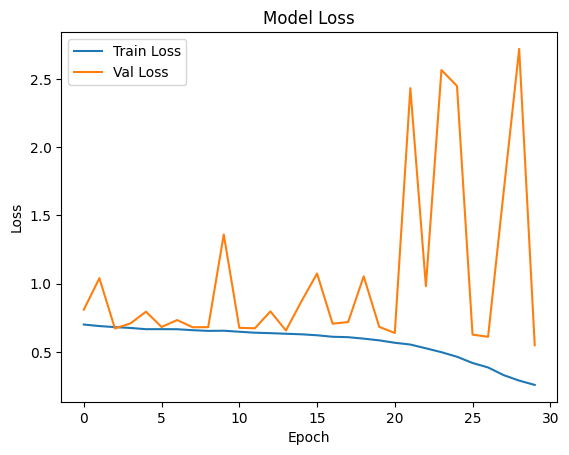

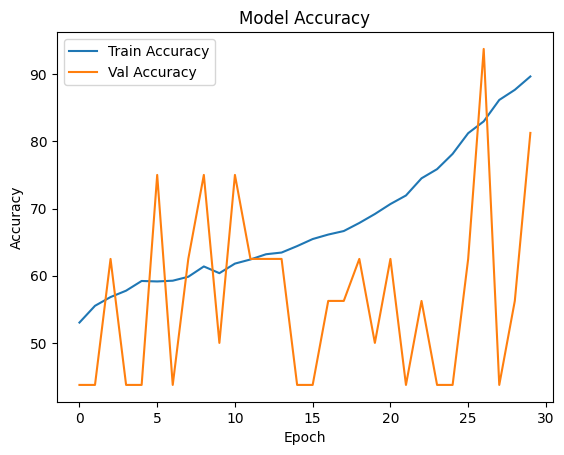

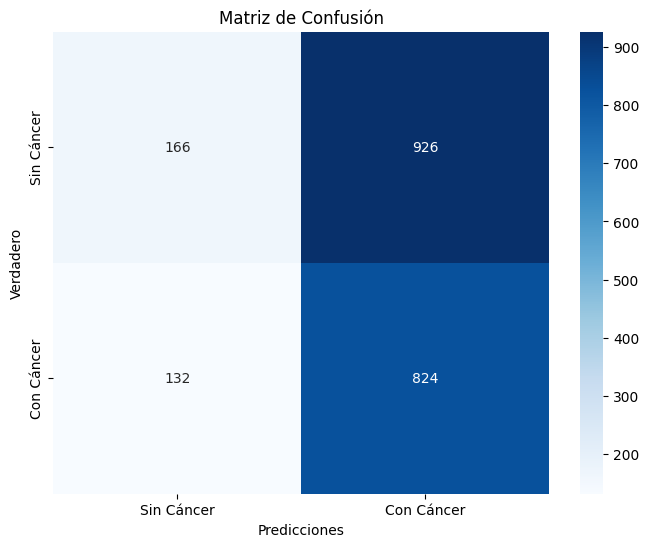

Precisión global: 48.34%
Informe y métricas de clasificación:
              precision    recall  f1-score   support

  Sin Cáncer       0.56      0.15      0.24      1092
  Con Cáncer       0.47      0.86      0.61       956

    accuracy                           0.48      2048
   macro avg       0.51      0.51      0.42      2048
weighted avg       0.52      0.48      0.41      2048

Precisión: 0.47
Sensibilidad (Recall): 0.86
F1-Score: 0.61
Accuracy: 0.48
Especificidad: 0.15


In [ ]:
models_list.append("vgg16bn");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(vgg16bn, test_loader, transform)

In [ ]:
## Resnet 50
resnet50 = models.resnet50(pretrained=False)
num_classes = 2
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repetir el canal de escala de grises para obtener 3 canales
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)
fichModelo = modelsdir + '/resnet50.pth'
eaStop = EarlyStopping(fichModelo, patience=15, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)
epochs = 30

train_loss, train_accu, val_loss, val_accu = trainModel(resnet50,train_loader,test_loader,criterion,optimizer,epochs,device,eaStop,transform)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/30: 100%|██████████| 619/619 [01:51<00:00,  5.53it/s]


Epoch [1/30], Train Loss: 0.735, Train Accuracy: 51.90%, Val Loss: 0.7138, Val Accuracy: 43.75%, Time: 118.84 seconds
Pérdida de validación mejorada a 0.713796. Guardando modelo...


Epoch 2/30: 100%|██████████| 619/619 [01:50<00:00,  5.61it/s]


Epoch [2/30], Train Loss: 0.702, Train Accuracy: 53.00%, Val Loss: 0.6905, Val Accuracy: 62.50%, Time: 117.30 seconds
Pérdida de validación mejorada a 0.690451. Guardando modelo...


Epoch 3/30: 100%|██████████| 619/619 [01:49<00:00,  5.64it/s]


Epoch [3/30], Train Loss: 0.693, Train Accuracy: 54.63%, Val Loss: 0.7266, Val Accuracy: 56.25%, Time: 116.71 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 4/30: 100%|██████████| 619/619 [01:49<00:00,  5.63it/s]


Epoch [4/30], Train Loss: 0.691, Train Accuracy: 55.40%, Val Loss: 0.6883, Val Accuracy: 68.75%, Time: 116.87 seconds
Pérdida de validación mejorada a 0.688260. Guardando modelo...


Epoch 5/30: 100%|██████████| 619/619 [01:49<00:00,  5.63it/s]


Epoch [5/30], Train Loss: 0.691, Train Accuracy: 54.63%, Val Loss: 0.6878, Val Accuracy: 62.50%, Time: 116.79 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 6/30: 100%|██████████| 619/619 [01:49<00:00,  5.64it/s]


Epoch [6/30], Train Loss: 0.689, Train Accuracy: 55.37%, Val Loss: 0.6805, Val Accuracy: 56.25%, Time: 116.63 seconds
Pérdida de validación mejorada a 0.680481. Guardando modelo...


Epoch 7/30: 100%|██████████| 619/619 [01:49<00:00,  5.67it/s]


Epoch [7/30], Train Loss: 0.688, Train Accuracy: 56.01%, Val Loss: 0.9481, Val Accuracy: 43.75%, Time: 116.04 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 8/30: 100%|██████████| 619/619 [01:49<00:00,  5.66it/s]


Epoch [8/30], Train Loss: 0.681, Train Accuracy: 57.14%, Val Loss: 0.7043, Val Accuracy: 56.25%, Time: 116.38 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 9/30: 100%|██████████| 619/619 [01:49<00:00,  5.64it/s]


Epoch [9/30], Train Loss: 0.680, Train Accuracy: 57.53%, Val Loss: 0.6746, Val Accuracy: 56.25%, Time: 116.72 seconds
Pérdida de validación mejorada a 0.674593. Guardando modelo...


Epoch 10/30: 100%|██████████| 619/619 [01:49<00:00,  5.64it/s]


Epoch [10/30], Train Loss: 0.670, Train Accuracy: 58.74%, Val Loss: 0.7078, Val Accuracy: 68.75%, Time: 116.69 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 11/30: 100%|██████████| 619/619 [01:49<00:00,  5.65it/s]


Epoch [11/30], Train Loss: 0.666, Train Accuracy: 58.91%, Val Loss: 0.7828, Val Accuracy: 43.75%, Time: 116.64 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 12/30: 100%|██████████| 619/619 [01:49<00:00,  5.66it/s]


Epoch [12/30], Train Loss: 0.663, Train Accuracy: 60.25%, Val Loss: 0.6851, Val Accuracy: 43.75%, Time: 116.16 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 13/30: 100%|██████████| 619/619 [01:48<00:00,  5.68it/s]


Epoch [13/30], Train Loss: 0.659, Train Accuracy: 59.77%, Val Loss: 0.6697, Val Accuracy: 68.75%, Time: 115.84 seconds
Pérdida de validación mejorada a 0.669730. Guardando modelo...


Epoch 14/30: 100%|██████████| 619/619 [01:49<00:00,  5.65it/s]


Epoch [14/30], Train Loss: 0.650, Train Accuracy: 61.42%, Val Loss: 0.6821, Val Accuracy: 56.25%, Time: 116.39 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 15/30: 100%|██████████| 619/619 [01:49<00:00,  5.67it/s]


Epoch [15/30], Train Loss: 0.649, Train Accuracy: 61.31%, Val Loss: 0.9012, Val Accuracy: 43.75%, Time: 116.07 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 16/30: 100%|██████████| 619/619 [01:49<00:00,  5.65it/s]


Epoch [16/30], Train Loss: 0.641, Train Accuracy: 62.98%, Val Loss: 0.6879, Val Accuracy: 56.25%, Time: 116.52 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 17/30: 100%|██████████| 619/619 [01:49<00:00,  5.64it/s]


Epoch [17/30], Train Loss: 0.632, Train Accuracy: 63.66%, Val Loss: 6.1220, Val Accuracy: 43.75%, Time: 116.63 seconds
EarlyStopping no mejoró por 4 épocas


Epoch 18/30: 100%|██████████| 619/619 [01:49<00:00,  5.65it/s]


Epoch [18/30], Train Loss: 0.624, Train Accuracy: 64.81%, Val Loss: 0.6808, Val Accuracy: 62.50%, Time: 116.47 seconds
EarlyStopping no mejoró por 5 épocas


Epoch 19/30: 100%|██████████| 619/619 [01:49<00:00,  5.65it/s]


Epoch [19/30], Train Loss: 0.608, Train Accuracy: 66.32%, Val Loss: 3.8203, Val Accuracy: 43.75%, Time: 116.62 seconds
EarlyStopping no mejoró por 6 épocas


Epoch 20/30: 100%|██████████| 619/619 [01:50<00:00,  5.63it/s]


Epoch [20/30], Train Loss: 0.597, Train Accuracy: 68.05%, Val Loss: 0.6435, Val Accuracy: 75.00%, Time: 117.03 seconds
Pérdida de validación mejorada a 0.643499. Guardando modelo...


Epoch 21/30: 100%|██████████| 619/619 [01:49<00:00,  5.64it/s]


Epoch [21/30], Train Loss: 0.564, Train Accuracy: 70.77%, Val Loss: 0.6261, Val Accuracy: 68.75%, Time: 116.54 seconds
Pérdida de validación mejorada a 0.626050. Guardando modelo...


Epoch 22/30: 100%|██████████| 619/619 [01:50<00:00,  5.61it/s]


Epoch [22/30], Train Loss: 0.533, Train Accuracy: 73.42%, Val Loss: 0.6335, Val Accuracy: 56.25%, Time: 117.29 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 23/30: 100%|██████████| 619/619 [01:49<00:00,  5.63it/s]


Epoch [23/30], Train Loss: 0.486, Train Accuracy: 76.58%, Val Loss: 0.6163, Val Accuracy: 56.25%, Time: 116.99 seconds
Pérdida de validación mejorada a 0.616321. Guardando modelo...


Epoch 24/30: 100%|██████████| 619/619 [01:49<00:00,  5.64it/s]


Epoch [24/30], Train Loss: 0.438, Train Accuracy: 79.93%, Val Loss: 0.8993, Val Accuracy: 68.75%, Time: 116.64 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 25/30: 100%|██████████| 619/619 [01:49<00:00,  5.64it/s]


Epoch [25/30], Train Loss: 0.386, Train Accuracy: 82.96%, Val Loss: 0.5868, Val Accuracy: 75.00%, Time: 116.73 seconds
Pérdida de validación mejorada a 0.586765. Guardando modelo...


Epoch 26/30: 100%|██████████| 619/619 [01:49<00:00,  5.64it/s]


Epoch [26/30], Train Loss: 0.331, Train Accuracy: 86.10%, Val Loss: 0.6498, Val Accuracy: 81.25%, Time: 116.60 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 27/30: 100%|██████████| 619/619 [01:49<00:00,  5.65it/s]


Epoch [27/30], Train Loss: 0.283, Train Accuracy: 88.05%, Val Loss: 0.5593, Val Accuracy: 75.00%, Time: 116.39 seconds
Pérdida de validación mejorada a 0.559288. Guardando modelo...


Epoch 28/30: 100%|██████████| 619/619 [01:49<00:00,  5.64it/s]


Epoch [28/30], Train Loss: 0.243, Train Accuracy: 89.68%, Val Loss: 0.6520, Val Accuracy: 81.25%, Time: 116.75 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 29/30: 100%|██████████| 619/619 [01:49<00:00,  5.64it/s]


Epoch [29/30], Train Loss: 0.209, Train Accuracy: 91.42%, Val Loss: 0.6151, Val Accuracy: 93.75%, Time: 116.67 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 30/30: 100%|██████████| 619/619 [01:49<00:00,  5.65it/s]


Epoch [30/30], Train Loss: 0.172, Train Accuracy: 93.22%, Val Loss: 0.8072, Val Accuracy: 87.50%, Time: 116.61 seconds
EarlyStopping no mejoró por 3 épocas


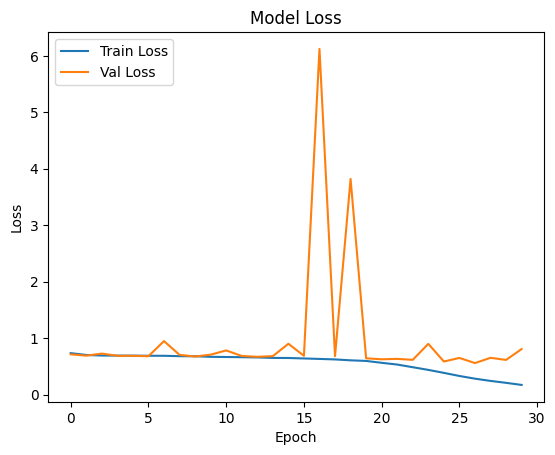

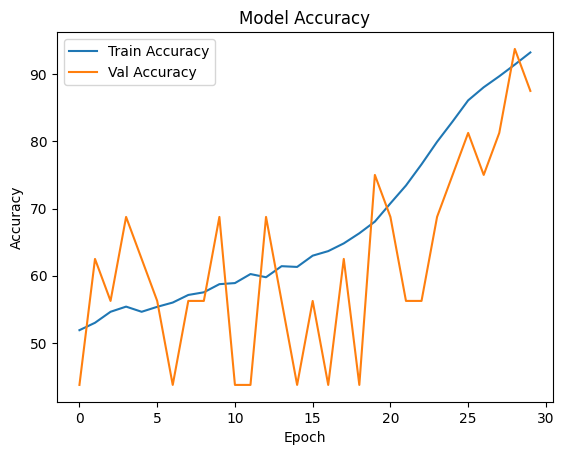

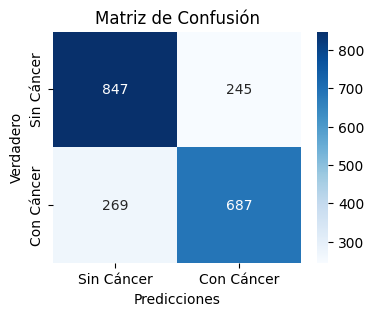

Precisión global: 74.90%
Informe y métricas de clasificación:
              precision    recall  f1-score   support

  Sin Cáncer       0.76      0.78      0.77      1092
  Con Cáncer       0.74      0.72      0.73       956

    accuracy                           0.75      2048
   macro avg       0.75      0.75      0.75      2048
weighted avg       0.75      0.75      0.75      2048

Precisión: 0.74
Sensibilidad (Recall): 0.72
F1-Score: 0.73
Accuracy: 0.75
Especificidad: 0.78


In [ ]:
models_list.append("resnet50");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(resnet50, test_loader, transform)

In [ ]:
### INCEPTION V3 SIN USAR PESOS PRECARGADOS

inceptionv3m = models.inception_v3(pretrained=False)
inceptionv3m.fc = nn.Linear(inceptionv3m.fc.in_features, 2)

inceptionv3m.aux_logits = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inceptionv3m.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(inceptionv3m.parameters(), lr=0.001)

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Resize((299, 299)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

fichModelo = modelsdir + '/inceptionv3m_fulltrained.pth'
eaStop = EarlyStopping(fichModelo, patience=5, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inceptionv3m.to(device)
epochs = 30

train_loss, train_accu, val_loss, val_accu = trainModel(inceptionv3m,train_loader,test_loader,criterion,optimizer,epochs,device,eaStop,fichModelo,transform)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
Epoch 1/30: 100%|██████████| 619/619 [02:40<00:00,  3.87it/s]


Epoch [1/30], Train Loss: 0.720, Train Accuracy: 53.68%, Val Loss: 0.8080, Val Accuracy: 56.25%, Time: 172.13 seconds
Pérdida de validación mejorada a 0.808047. Guardando modelo...


Epoch 2/30: 100%|██████████| 619/619 [02:39<00:00,  3.87it/s]


Epoch [2/30], Train Loss: 0.704, Train Accuracy: 54.39%, Val Loss: 0.6945, Val Accuracy: 62.50%, Time: 171.73 seconds
Pérdida de validación mejorada a 0.694506. Guardando modelo...


Epoch 3/30: 100%|██████████| 619/619 [02:39<00:00,  3.88it/s]


Epoch [3/30], Train Loss: 0.696, Train Accuracy: 53.87%, Val Loss: 0.7223, Val Accuracy: 43.75%, Time: 171.17 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 4/30: 100%|██████████| 619/619 [02:39<00:00,  3.88it/s]


Epoch [4/30], Train Loss: 0.691, Train Accuracy: 55.70%, Val Loss: 0.7825, Val Accuracy: 37.50%, Time: 171.23 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 5/30: 100%|██████████| 619/619 [02:39<00:00,  3.89it/s]


Epoch [5/30], Train Loss: 0.690, Train Accuracy: 56.19%, Val Loss: 0.6969, Val Accuracy: 56.25%, Time: 171.13 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 6/30: 100%|██████████| 619/619 [02:38<00:00,  3.90it/s]


Epoch [6/30], Train Loss: 0.684, Train Accuracy: 57.29%, Val Loss: 1.0689, Val Accuracy: 43.75%, Time: 170.90 seconds
EarlyStopping no mejoró por 4 épocas


Epoch 7/30: 100%|██████████| 619/619 [02:39<00:00,  3.89it/s]


Epoch [7/30], Train Loss: 0.679, Train Accuracy: 58.38%, Val Loss: 0.6936, Val Accuracy: 50.00%, Time: 170.89 seconds
EarlyStopping no mejoró por 5 épocas
Early Stopping activado. Proceso detenido!


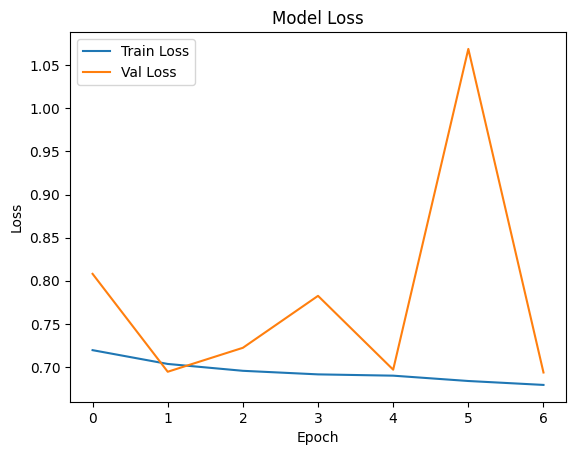

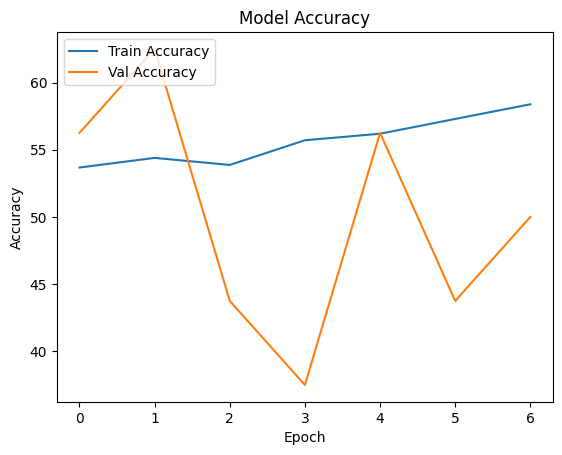

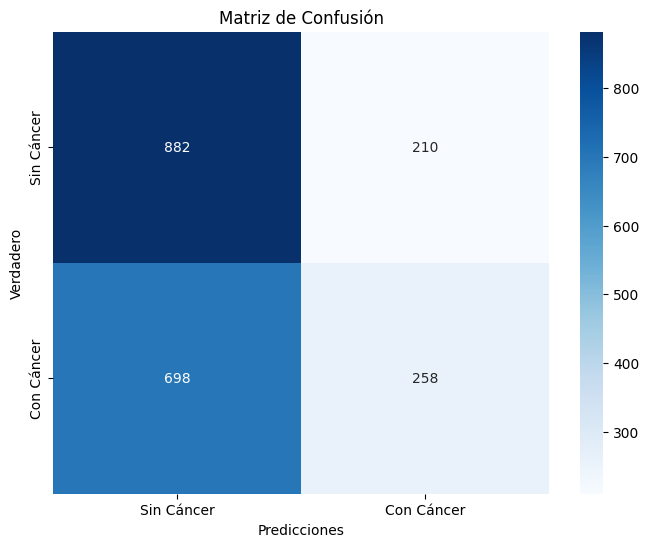

Precisión global: 55.66%
Informe y métricas de clasificación:
              precision    recall  f1-score   support

  Sin Cáncer       0.56      0.81      0.66      1092
  Con Cáncer       0.55      0.27      0.36       956

    accuracy                           0.56      2048
   macro avg       0.55      0.54      0.51      2048
weighted avg       0.55      0.56      0.52      2048

Precisión: 0.55
Sensibilidad (Recall): 0.27
F1-Score: 0.36
Accuracy: 0.56
Especificidad: 0.81


In [ ]:
models_list.append("inceptionv3m");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(inceptionv3m, test_loader, transform)

In [ ]:
from torchvision.models import DenseNet201_Weights
densenet201 = models.densenet201(weights=DenseNet201_Weights.DEFAULT)  # Cargar el modelo pre-entrenado
num_classes = 2
num_ftrs = densenet201.classifier.in_features
densenet201.classifier = nn.Linear(num_ftrs, num_classes)

# Transformaciones para entrenamiento y validación
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet201.parameters(), lr=0.001)

fichModelo = modelsdir + '/densenet201.pth'
eaStop = EarlyStopping(fichModelo, patience=20, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet201.to(device)
epochs = 30

train_loss, train_accu, val_loss, val_accu = trainModel(densenet201,train_loader,test_loader,criterion,optimizer,epochs,device,eaStop,transform)

Epoch 1/30: 100%|██████████| 619/619 [01:33<00:00,  6.64it/s]


Epoch [1/30], Train Loss: 0.718, Train Accuracy: 50.04%, Val Loss: 0.6976, Val Accuracy: 43.75%, Time: 98.39 seconds
Pérdida de validación mejorada a 0.697607. Guardando modelo...


Epoch 2/30: 100%|██████████| 619/619 [01:33<00:00,  6.61it/s]


Epoch [2/30], Train Loss: 0.709, Train Accuracy: 51.45%, Val Loss: 0.6867, Val Accuracy: 50.00%, Time: 98.74 seconds
Pérdida de validación mejorada a 0.686730. Guardando modelo...


Epoch 3/30: 100%|██████████| 619/619 [01:32<00:00,  6.68it/s]


Epoch [3/30], Train Loss: 0.697, Train Accuracy: 53.03%, Val Loss: 0.6986, Val Accuracy: 31.25%, Time: 97.81 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 4/30: 100%|██████████| 619/619 [01:32<00:00,  6.66it/s]


Epoch [4/30], Train Loss: 0.687, Train Accuracy: 55.79%, Val Loss: 0.7533, Val Accuracy: 50.00%, Time: 98.01 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 5/30: 100%|██████████| 619/619 [01:33<00:00,  6.60it/s]


Epoch [5/30], Train Loss: 0.691, Train Accuracy: 54.70%, Val Loss: 0.7056, Val Accuracy: 56.25%, Time: 98.89 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 6/30: 100%|██████████| 619/619 [01:32<00:00,  6.69it/s]


Epoch [6/30], Train Loss: 0.687, Train Accuracy: 55.22%, Val Loss: 0.7084, Val Accuracy: 62.50%, Time: 97.65 seconds
EarlyStopping no mejoró por 4 épocas


Epoch 7/30: 100%|██████████| 619/619 [01:31<00:00,  6.73it/s]


Epoch [7/30], Train Loss: 0.680, Train Accuracy: 57.23%, Val Loss: 0.6955, Val Accuracy: 62.50%, Time: 96.95 seconds
EarlyStopping no mejoró por 5 épocas


Epoch 8/30: 100%|██████████| 619/619 [01:31<00:00,  6.73it/s]


Epoch [8/30], Train Loss: 0.675, Train Accuracy: 58.02%, Val Loss: 0.6891, Val Accuracy: 50.00%, Time: 97.05 seconds
EarlyStopping no mejoró por 6 épocas


Epoch 9/30: 100%|██████████| 619/619 [01:31<00:00,  6.77it/s]


Epoch [9/30], Train Loss: 0.675, Train Accuracy: 57.94%, Val Loss: 0.8023, Val Accuracy: 43.75%, Time: 96.40 seconds
EarlyStopping no mejoró por 7 épocas


Epoch 10/30: 100%|██████████| 619/619 [01:31<00:00,  6.76it/s]


Epoch [10/30], Train Loss: 0.668, Train Accuracy: 59.58%, Val Loss: 0.6691, Val Accuracy: 68.75%, Time: 96.47 seconds
Pérdida de validación mejorada a 0.669073. Guardando modelo...


Epoch 11/30: 100%|██████████| 619/619 [01:31<00:00,  6.75it/s]


Epoch [11/30], Train Loss: 0.669, Train Accuracy: 58.96%, Val Loss: 0.6588, Val Accuracy: 62.50%, Time: 96.77 seconds
Pérdida de validación mejorada a 0.658846. Guardando modelo...


Epoch 12/30: 100%|██████████| 619/619 [01:31<00:00,  6.75it/s]


Epoch [12/30], Train Loss: 0.660, Train Accuracy: 60.66%, Val Loss: 1.0019, Val Accuracy: 56.25%, Time: 96.57 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 13/30: 100%|██████████| 619/619 [01:31<00:00,  6.75it/s]


Epoch [13/30], Train Loss: 0.649, Train Accuracy: 61.75%, Val Loss: 0.7044, Val Accuracy: 56.25%, Time: 96.60 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 14/30: 100%|██████████| 619/619 [01:31<00:00,  6.78it/s]


Epoch [14/30], Train Loss: 0.649, Train Accuracy: 61.91%, Val Loss: 0.6712, Val Accuracy: 56.25%, Time: 96.31 seconds
EarlyStopping no mejoró por 3 épocas


Epoch 15/30: 100%|██████████| 619/619 [01:31<00:00,  6.77it/s]


Epoch [15/30], Train Loss: 0.634, Train Accuracy: 63.38%, Val Loss: 0.7109, Val Accuracy: 56.25%, Time: 96.40 seconds
EarlyStopping no mejoró por 4 épocas


Epoch 16/30: 100%|██████████| 619/619 [01:31<00:00,  6.75it/s]


Epoch [16/30], Train Loss: 0.629, Train Accuracy: 64.08%, Val Loss: 0.6709, Val Accuracy: 50.00%, Time: 96.67 seconds
EarlyStopping no mejoró por 5 épocas


Epoch 17/30: 100%|██████████| 619/619 [01:31<00:00,  6.73it/s]


Epoch [17/30], Train Loss: 0.620, Train Accuracy: 65.47%, Val Loss: 0.6829, Val Accuracy: 68.75%, Time: 96.91 seconds
EarlyStopping no mejoró por 6 épocas


Epoch 18/30: 100%|██████████| 619/619 [01:31<00:00,  6.75it/s]


Epoch [18/30], Train Loss: 0.614, Train Accuracy: 66.00%, Val Loss: 0.6964, Val Accuracy: 62.50%, Time: 96.63 seconds
EarlyStopping no mejoró por 7 épocas


Epoch 19/30: 100%|██████████| 619/619 [01:31<00:00,  6.75it/s]


Epoch [19/30], Train Loss: 0.599, Train Accuracy: 67.68%, Val Loss: 0.6586, Val Accuracy: 56.25%, Time: 96.59 seconds
EarlyStopping no mejoró por 8 épocas


Epoch 20/30: 100%|██████████| 619/619 [01:31<00:00,  6.78it/s]


Epoch [20/30], Train Loss: 0.584, Train Accuracy: 68.95%, Val Loss: 0.6843, Val Accuracy: 56.25%, Time: 96.28 seconds
EarlyStopping no mejoró por 9 épocas


Epoch 21/30: 100%|██████████| 619/619 [01:32<00:00,  6.72it/s]


Epoch [21/30], Train Loss: 0.555, Train Accuracy: 71.11%, Val Loss: 0.8464, Val Accuracy: 50.00%, Time: 97.26 seconds
EarlyStopping no mejoró por 10 épocas


Epoch 22/30: 100%|██████████| 619/619 [01:32<00:00,  6.72it/s]


Epoch [22/30], Train Loss: 0.529, Train Accuracy: 73.77%, Val Loss: 0.6626, Val Accuracy: 56.25%, Time: 97.13 seconds
EarlyStopping no mejoró por 11 épocas


Epoch 23/30: 100%|██████████| 619/619 [01:31<00:00,  6.74it/s]


Epoch [23/30], Train Loss: 0.503, Train Accuracy: 75.54%, Val Loss: 0.6339, Val Accuracy: 62.50%, Time: 96.87 seconds
Pérdida de validación mejorada a 0.633874. Guardando modelo...


Epoch 24/30: 100%|██████████| 619/619 [01:32<00:00,  6.73it/s]


Epoch [24/30], Train Loss: 0.467, Train Accuracy: 77.99%, Val Loss: 0.5931, Val Accuracy: 75.00%, Time: 97.07 seconds
Pérdida de validación mejorada a 0.593133. Guardando modelo...


Epoch 25/30: 100%|██████████| 619/619 [01:31<00:00,  6.73it/s]


Epoch [25/30], Train Loss: 0.428, Train Accuracy: 80.69%, Val Loss: 2.3947, Val Accuracy: 43.75%, Time: 96.97 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 26/30: 100%|██████████| 619/619 [01:32<00:00,  6.72it/s]


Epoch [26/30], Train Loss: 0.373, Train Accuracy: 84.16%, Val Loss: 2.0406, Val Accuracy: 43.75%, Time: 97.02 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 27/30: 100%|██████████| 619/619 [01:31<00:00,  6.74it/s]


Epoch [27/30], Train Loss: 0.333, Train Accuracy: 85.81%, Val Loss: 0.5630, Val Accuracy: 68.75%, Time: 97.00 seconds
Pérdida de validación mejorada a 0.563001. Guardando modelo...


Epoch 28/30: 100%|██████████| 619/619 [01:31<00:00,  6.73it/s]


Epoch [28/30], Train Loss: 0.296, Train Accuracy: 87.91%, Val Loss: 0.6272, Val Accuracy: 75.00%, Time: 97.07 seconds
EarlyStopping no mejoró por 1 épocas


Epoch 29/30: 100%|██████████| 619/619 [01:31<00:00,  6.73it/s]


Epoch [29/30], Train Loss: 0.260, Train Accuracy: 89.30%, Val Loss: 0.8128, Val Accuracy: 50.00%, Time: 96.99 seconds
EarlyStopping no mejoró por 2 épocas


Epoch 30/30: 100%|██████████| 619/619 [01:32<00:00,  6.73it/s]


Epoch [30/30], Train Loss: 0.232, Train Accuracy: 90.71%, Val Loss: 0.6108, Val Accuracy: 87.50%, Time: 97.06 seconds
EarlyStopping no mejoró por 3 épocas


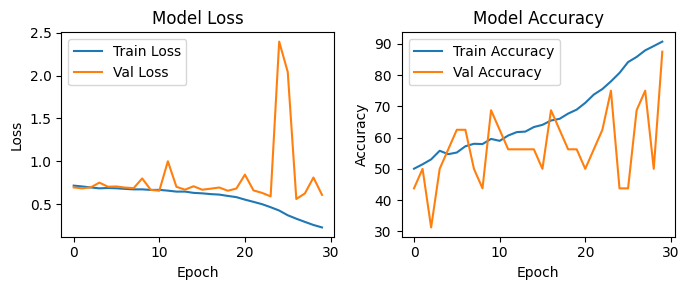

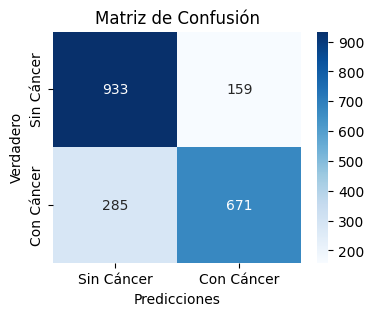

Precisión global: 78.32%
Informe y métricas de clasificación:
              precision    recall  f1-score   support

  Sin Cáncer       0.77      0.85      0.81      1092
  Con Cáncer       0.81      0.70      0.75       956

    accuracy                           0.78      2048
   macro avg       0.79      0.78      0.78      2048
weighted avg       0.79      0.78      0.78      2048

Precisión: 0.81
Sensibilidad (Recall): 0.70
F1-Score: 0.75
Accuracy: 0.78
Especificidad: 0.85


In [ ]:
models_list.append("densenet201");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(densenet201, test_loader, transform)